## Introduction

This project demonstrates the end-to-end implementation of a recommendation system using TensorFlow Recommenders (TFRS). The system is designed to deliver personalized product recommendations by analyzing user interactions such as searches, clicks, add-to-cart actions, and purchases. It leverages a dataset of user interaction data sourced from an e-commerce platform to tailor recommendations to individual preferences, enhancing the shopping experience with relevant product suggestions.

## Imports

In [2]:
# Data processing and Modelling
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
from keras.src.utils import io_utils
import ImbalancedLearningRegression as iblr
from sklearn.model_selection import train_test_split, KFold
from tensorboard.plugins import projector
import optuna
from optuna.exceptions import TrialPruned
from optuna.trial import TrialState

# Visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from wordcloud import WordCloud
import logging

# Utils
import os, json, re, time, sys, copy, pprint
from typing import Any, Dict
from tqdm import tqdm
from itertools import zip_longest
from collections import Counter
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set up basic configuration for logging
logging.basicConfig(
    stream=sys.stdout,
    level=logging.INFO, 
    format='%(asctime)s - %(levelname)s - %(message)s',
    force= True
)

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)

# Set Seaborn style
sns.set_style('darkgrid') 
sns.set_context('notebook')
sns.set_palette('colorblind')

2024-11-30 15:48:06.831219: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 15:48:06.831827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 15:48:06.833500: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs available:")
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print(f"Device: {gpu.name}")
        print("Details:", details)
else:
    print("No GPUs available.")

GPUs available:
Device: /physical_device:GPU:0
Details: {'compute_capability': (6, 0), 'device_name': 'Tesla P100-PCIE-16GB'}


## Load Data

In [ ]:
raw_data = pd.read_parquet(os.path.join("data", "search_sample_data.parquet"))

# Rename and order columns
columns = [
    'time', 'user_id', 'product_id', 'merchant_id', 'category_id', 
    'channel', 'query_text', 'device_type', 'sales_last_week',
    'sales_last_month', 'sales_last_year', 'previous_purchase',
    'free_shipping', 'is_sold_out', 'editor_pick', 'merchant_name',
    'product_name', 'price_in_cents', 'on_sale', 'category_name',
    'merchant_city', 'merchant_state', 'merchant_region', 'reviews',
    'add_to_cart', 'click', 'conversion'
]
data_df = raw_data.copy()
data_df.columns = data_df.columns.str.lower()
data_df.rename(columns = {'visitor_token':'user_id'}, inplace = True)
data_df = data_df.reindex(columns, axis = 1)

# Convert to numeric
cols_to_int = [
    'previous_purchase', 'free_shipping', 'is_sold_out', 'editor_pick',
    'on_sale', 'price_in_cents', 'reviews', 'add_to_cart', 'click', 'conversion'
]
data_df[cols_to_int] = data_df[cols_to_int].astype(int)

# Order by timestamp, neeeded by sequential features
data_df = data_df.sort_values(by=['time']).reset_index(drop = True)

## Dataset Overview
There wasn't information available from the data source. So, I will have to figure out the meaning of the features.

### Summary Statistics

In [5]:
# Make a copy to the original dataframe for analysis only
analysis_df = data_df.copy()
analysis_df[['click', 'add_to_cart', 'conversion']] = analysis_df[['click', 'add_to_cart', 'conversion']].replace({0: 'No', 1: 'Yes'})

def describe_df(df: pd.DataFrame):
    # Replace empty strings with NaN
    df.replace("", np.nan, inplace=True)

    # Descriptive statistics
    temp = df.describe(include="all").drop(["count", "unique"]).T.fillna("-")
    temp.insert(loc=0, column='Dtype', value=[df[f].dtype for f in df])
    temp.insert(loc=1, column='nunique', value=df.nunique())
    temp.insert(loc=2, column='5 unique samples', value=[df[f].unique()[:5] for f in df])
    temp.insert(loc=3, column='nulls', value=df.isnull().sum())
    temp.insert(loc=4, column='nulls%', value=df.isnull().mean() * 100)
    temp = temp.style.background_gradient(cmap='Reds', axis=0).format(precision=2)

    return temp

describe_df(analysis_df)

,Dtype,nunique,5 unique samples,nulls,nulls%,top,freq,mean,min,25%,50%,75%,max,std
time,datetime64[ms],66063,"['2023-10-25 00:00:00.239000', '2023-10-25 00:00:04.782000', '2023-10-25 00:00:09.976000', '2023-10-25 00:00:13.436000', '2023-10-25 00:00:19.230000'] Length: 5, dtype: datetime64[ms]",0,0.00,-,-,2023-10-30 02:42:08.604000,2023-10-25 00:00:00.239000,2023-10-27 14:19:21.592000,2023-10-30 04:22:31.149000,2023-11-01 18:27:23.707000,2023-11-03 23:59:57.489000,-
user_id,object,36139,['0128154c352c99728ee8751b4195edf1' 'be5a2be5ba0512cd2760d238db4ab081' '429aaefb44eec755f343cbf11a1c5e35' '984bc819922189826223473d93c1eb05' 'b7485193f4e7f5b8ac3c94f71f4456a9'],0,0.00,5e3d4b4e9fe3d0b2c141545df152d248,99,-,-,-,-,-,-,-
product_id,object,9291,['b718927467331a24416eff42b2de0baa' 'b3f3f61b98f0fb22f7ec1c4bc1134047' '6bf216c19a268e5526e7dac82bf97075' '53ebf70c18f22c5bca530cf6baa0a362' '348f161dc5118d0981244cd24e95427f'],0,0.00,f8cae79a13f055aef7f494d750c85fdf,438,-,-,-,-,-,-,-
merchant_id,object,851,['7a759c49dbfa76d5f6a37bc92672d4ab' '018c7a5ba47ad79a8c58b0ee5695d62c' '293e73158ae0ec24bda7ddecf0368094' '8ecd51f99303ef15f7851db6d0447d15' 'e5f068e9b1f03449fe6e67a931ce84e0'],0,0.00,dc9b8b5db6bf249c30a04fa99be3de43,1623,-,-,-,-,-,-,-
category_id,object,329,['eae2be8310696802d013f0053cefa26b' '35a55705fa967b51b55bc1956fe69e19' '701e4d9be4e0679c5d1ffa62a0d0b1f8' 'faefe0110e721dc3ea7df010e66ce59f' '1b873b70b598b2b8870726342334ac18'],0,0.00,d332ed8693caa0ed046759d7f3983748,5552,-,-,-,-,-,-,-
channel,object,16,['Paid Social' 'Paid Search - Brand' 'Organic' 'Email - Transactional' 'Affiliate'],0,0.00,Direct,46000,-,-,-,-,-,-,-
query_text,object,15246,['princess cake' 'crab legs' 'chicago' 'rye bread' 'pizza'],192,0.15,thanksgiving dinners,1721,-,-,-,-,-,-,-
device_type,object,7,['Mobile' 'Desktop' 'Phablet' 'Tablet' nan],428,0.32,Mobile,70360,-,-,-,-,-,-,-
sales_last_week,int64,42,[11 5 9 12 2],0,0.00,-,-,7.36,0.00,4.00,7.00,10.00,41.00,4.13
sales_last_month,int64,59,[12 8 10 15 2],0,0.00,-,-,9.70,0.00,6.00,9.00,12.00,58.00,5.83


Analysis:
- There is only one week of data available (from 25-10-2023 to 03-11-2023).
- It isn't clear to whose variable belong `sales_last_week`, `sales_last_month`, `sales_last_year`, `previous_purchase`, if it's related to the merchant, to the product, or to the category. 
- I don't understand the meaning of the `editor_pick` feature.
- Some features have nulls, but there represents less than 1% of the data in most of them.
- `merchant_region` has the most nulls. But this values can be imputed from `merchant_state`, which has not nulls.
- The most query search is *thanksgiving dinners*.
- *Carrot Cake* is the most popular product.
- *Russ & Daughters* is the most popular merchant.
- *New York* is the most popular merchant city.

### Distributions

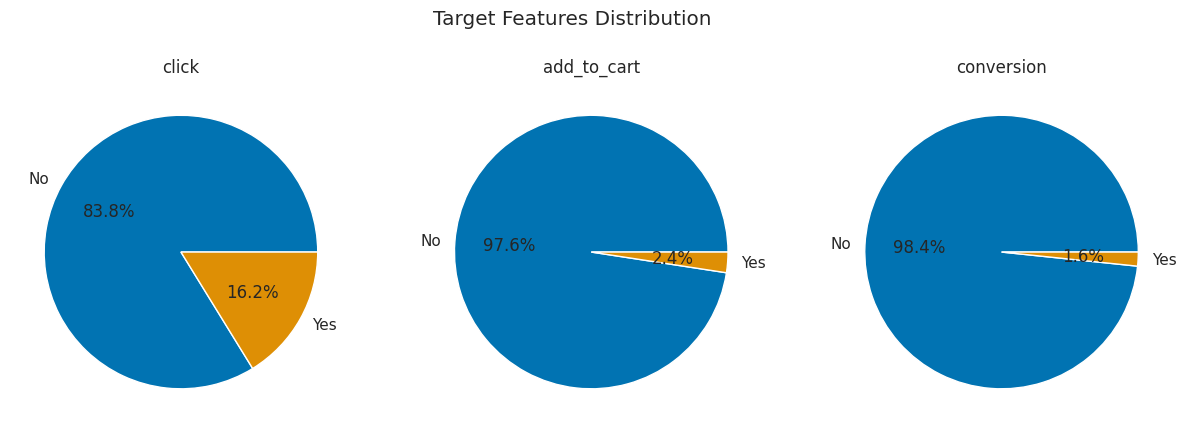

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Target Features Distribution')
for i, feature in enumerate(['click', 'add_to_cart', 'conversion']):
    analysis_df[feature].value_counts().plot(kind='pie', ax=ax[i], autopct='%1.1f%%')
    ax[i].set_title(feature)
    ax[i].set_ylabel('')

Like I expected, clicks, add-to-cart and conversions (purchases) are **sparse**.

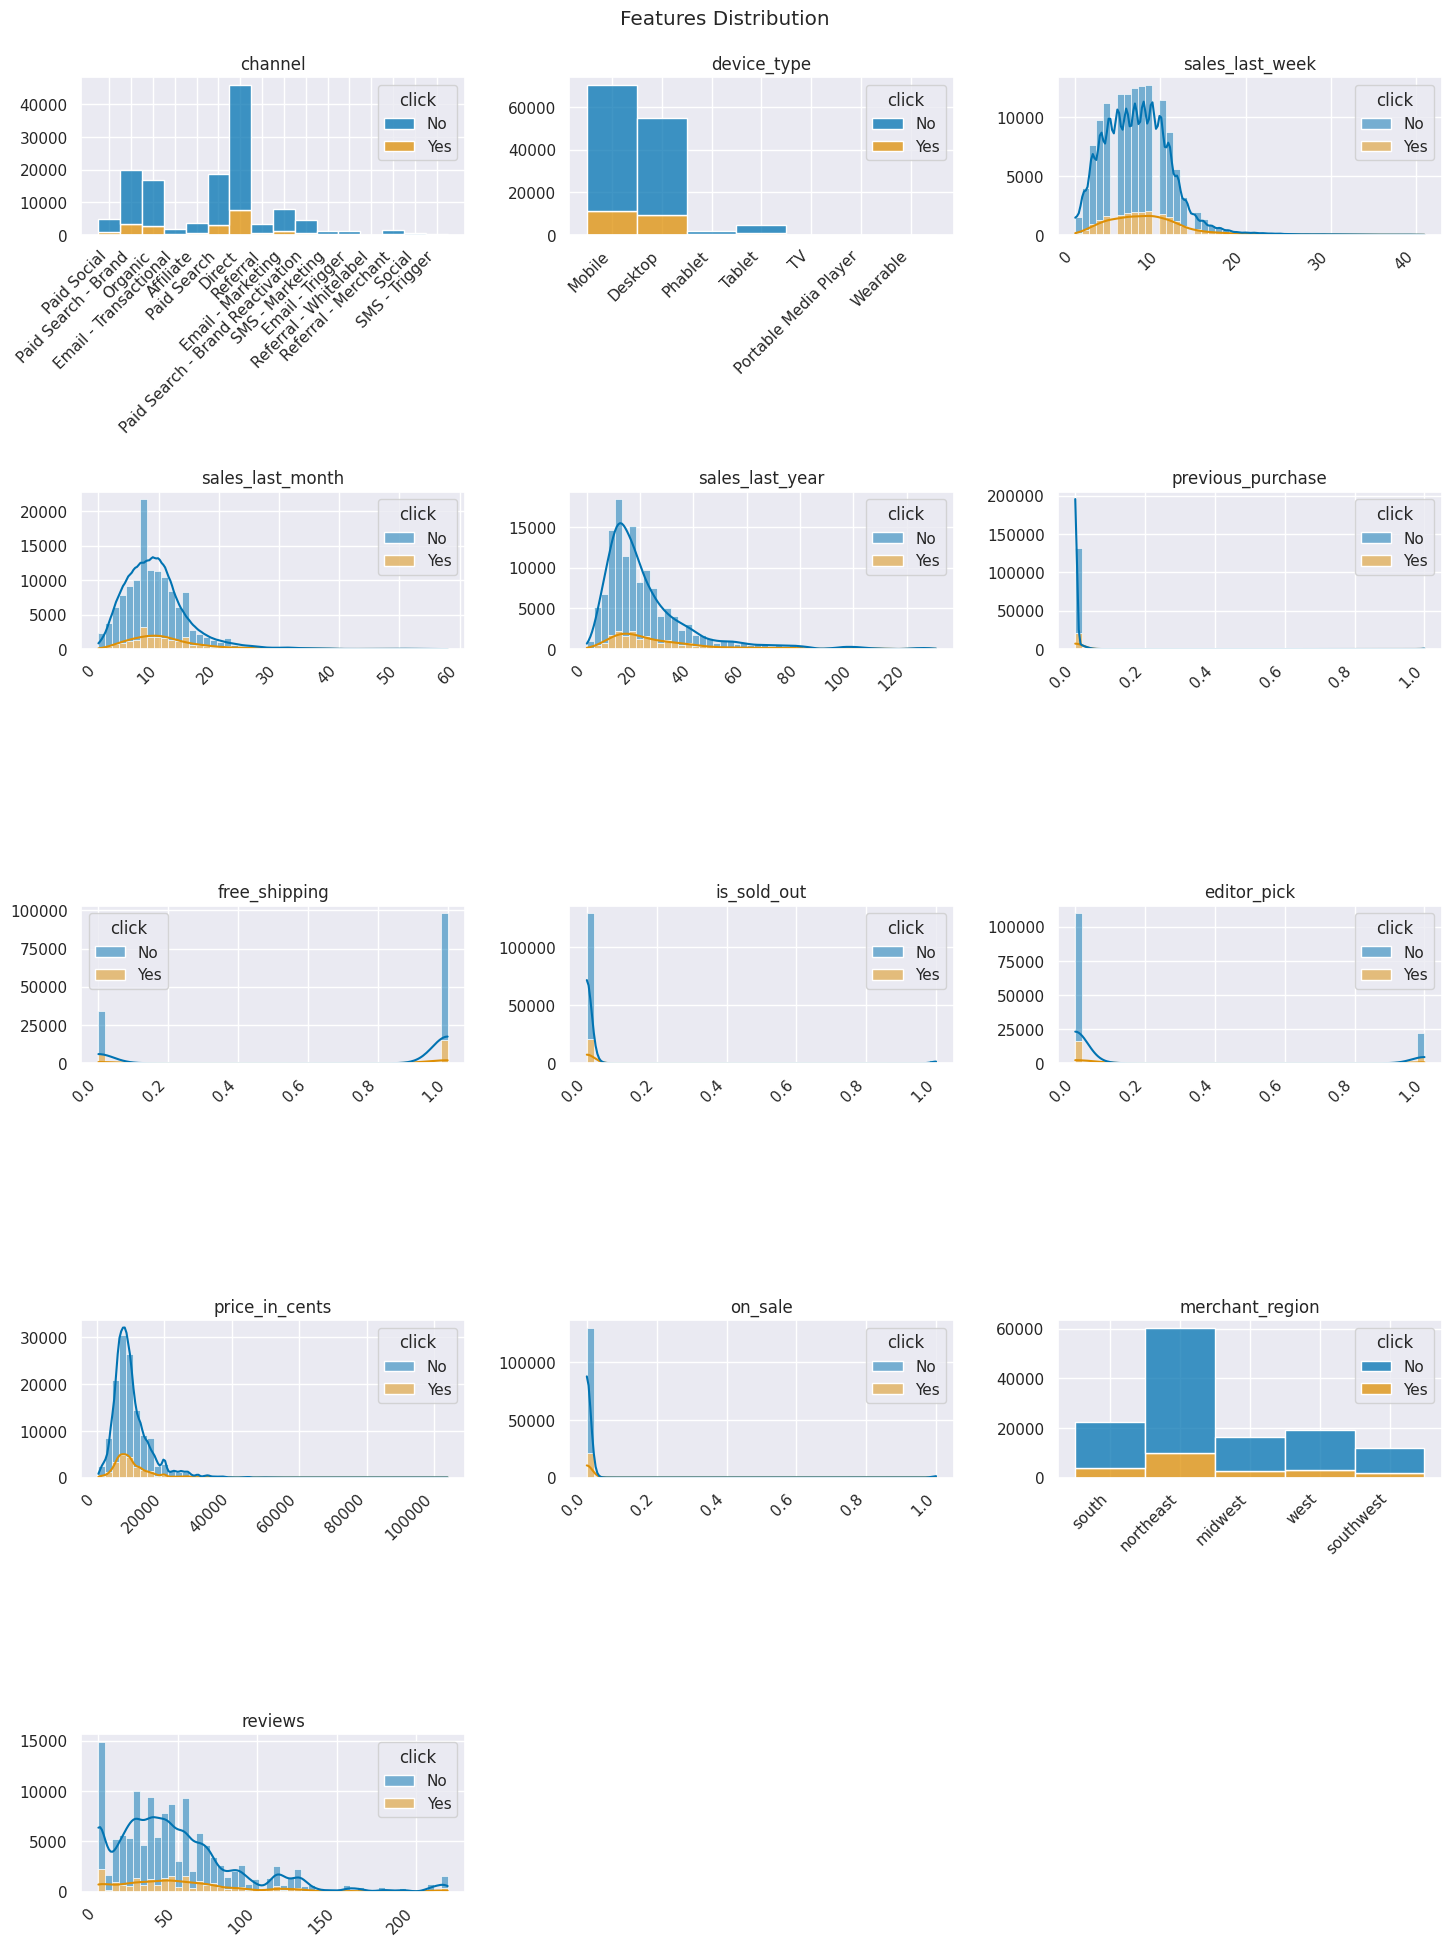

In [7]:
# I will drop columns that contain high cardinality
cols_to_drop = [
    'time', 'user_id', 'product_id', 'merchant_id', 'category_id',
    'query_text', 'merchant_name', 'product_name', 'category_name', 'merchant_city',
    'merchant_state'
]

# Display Distributions
def display_distributions(df: pd.DataFrame, cols: list[str] = None, target: str = None):
    df = df.drop(cols, axis = 1)
    features = df.drop(target, axis=1).columns
    rows = len(features) // 3 if len(features) % 3 == 0 else len(features) // 3 + 1    
    
    fig, axes = plt.subplots(rows, 3, figsize=(15, 20))
    for i, feature in enumerate(features):
        ax = axes.ravel()[i]
        sns.histplot(df,
                        x=feature,
                        hue=target,
                        multiple="stack",
                        ax=ax, bins=50,
                        kde=True if df[feature].dtype not in ['O', 'category'] else False)
        
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_title(feature)

        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_ha('right')
    
    # Hide any unused axes
    for j in range(len(features), len(axes.ravel())):
        axes.ravel()[j].set_visible(False)
    
    fig.suptitle('Features Distribution')
    plt.tight_layout(pad=2 )
    plt.show()


display_distributions(analysis_df, cols= cols_to_drop + ['add_to_cart', 'conversion'], target= 'click')

Analysis:
- *Direct* is the most popular `channel`.
- *Mobile* and *Desktop* are the most popular `device_type`.
- `sales_last_week`, `sales_last_month`, `sales_last_year`, `price_in_cents` and `reviews` are **left-skewed**.
- Most of the products have *free shipping*.
- `previous_purchase`, `is_sold_out`, `editor_pick` and `on_sale` are highly **skewed**.

### Correlations

In [8]:
def correlation(df:pd.DataFrame=None, cols: list=[str]):
    df = df.drop(cols, axis=1)
    not_number = df.select_dtypes(exclude='number').columns
    # Factorize categorical features
    df[not_number] = df[not_number].apply(lambda x: pd.factorize(x)[0])
    correlation_matrix = df.corr(numeric_only=True)
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    correlation_matrix = correlation_matrix.mask(mask)
    return px.imshow(correlation_matrix,
            labels=dict(color="Correlation"),
            x=correlation_matrix.index,
            y=correlation_matrix.columns,
            color_continuous_scale='Viridis').update_layout(title="Features Correlation", height = 700, width = 1000)

correlation(analysis_df, cols= cols_to_drop + ['merchant_region'])

Analysis:
- `sales_last_week`, `sales_last_month`, `sales_last_year` are highly **correlated** between them and with `editor_pick` and `reviews`.
- target features `click`, `add_to_cart`, `conversion` are **highly correlated** as expected.
- `price_in_cents` and `free_shipping` are **slightly positive correlation**. That means if the price of an item is higher, it's more likely to have free shipping.
- interesting **negative correlation** between `free_shipping` and `reviews`.
- **slightly negative correlation** between `price_in_cents` and `reviews` indicating that if a product is expensive, it's more likely to have fewer reviews.

### Word Cloud

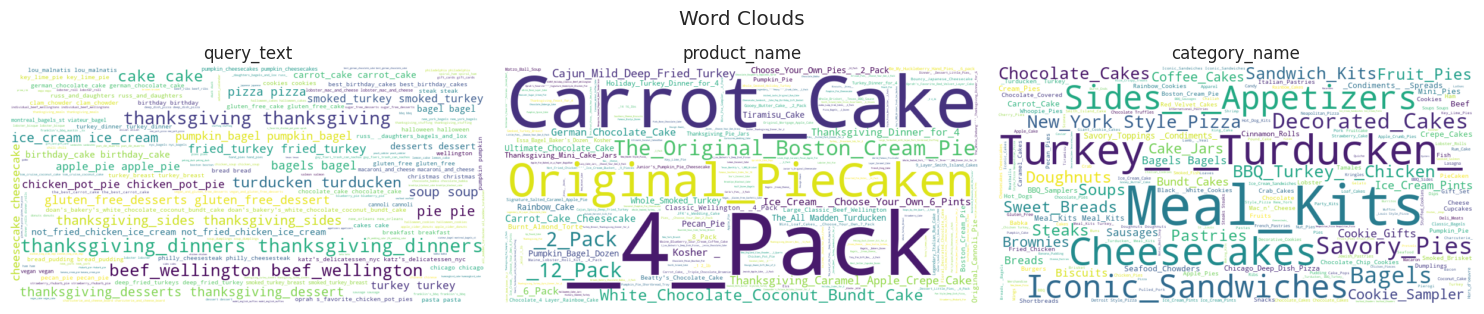

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, feature in enumerate(['query_text', 'product_name', 'category_name']):
    text = analysis_df[feature].dropna().apply(lambda x: x.replace(" ", "_")).str.cat(sep=" ")
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    ax[i].imshow(wordcloud, interpolation='bilinear')  # Display the word cloud image
    ax[i].axis("off")  # Turn off the axis
    ax[i].set_title(feature)

fig.suptitle('Word Clouds')
plt.tight_layout(rect=[0, 0.03, 1, 1.3])  # Adjust layout to make space for suptitle
plt.show()  

## Data Preparation

### Clicks Dataset
In order to do a retrieval task, I need to separate positive interactions from negative ones. **Clicks are assumed as positive interactions**. 
On the other hand, I need a **score feature** to rank products by the feedback received by the user. I will use the following weights to create this feature:

|Score|Add to Cart|Conversion|
|----|----|----|
|`0.0`|No|No|
|`0.5`|Yes|No|
|`1.0`|No/Yes|Yes|



In [10]:
# Create score feature
def create_clicks_dataset(df: pd.DataFrame, add_to_cart_score: float= 0.5, conversion_score: float = 1.0) -> pd.DataFrame:
    df = df[df['click'] == True].reset_index(drop=True)
    df['score'] = np.where(df['conversion'] == True, conversion_score, np.where(df['add_to_cart'] == True, add_to_cart_score, 0.0))
    return df

# Filter only clicks
clicks_df = create_clicks_dataset(data_df, 0.5, 1.0)

assert clicks_df.shape == (data_df[data_df['click'] == True].shape[0], data_df.shape[1] + 1), "Invalid Clicks dataset shape."

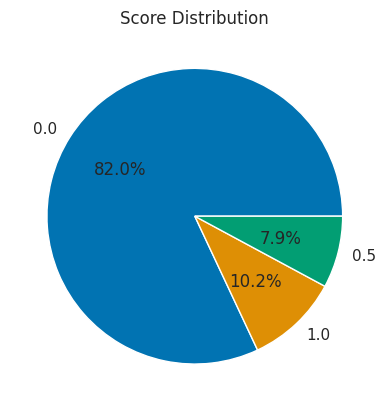

In [11]:
clicks_df['score'].value_counts(normalize=True).plot(kind='pie', title= "Score Distribution", ylabel= '', autopct='%1.1f%%')
plt.show()

### Items Dataset

For the items dataset, I will retain only the most recent features (ordered by time) to represent the current state of each product. This is because certain features, such as `free_shipping`, `price_in_cents`, `reviews`, etc., fluctuate over time.

The primary keys for the items dataset are `product_id` and `merchant_id`. However, since `merchant_id` can be mapped to a specific `merchant_name`, I will use `merchant_name` as the merchant identifier in the model.

Due to some inconsistencies in spelling, I will ensure that each [`product_id`, `merchant_name`] group has a single [`product_name`, `category_name`]. To achieve this, I will select the most frequent value (the mode) for this group to serve as the correct one.

In a real scenario, I would have a item database that would be up-to-date with the latest features.

In [12]:
# Ensure data is ordered by time
assert data_df['time'].is_monotonic_increasing, "DataFrame is not ordered by timestamp in ascending order."

products_df = data_df.groupby(["product_id", "merchant_name"]).last().reset_index() # Retain only last product

# modify clicks dataset with the new values of product_name and category_name
def adapt_clicks(df: pd.DataFrame) -> pd.DataFrame:
    merged = df.merge(products_df, on = ['product_id', 'merchant_name'])
    df[['product_name', 'category_name']] = merged[['product_name_y', 'category_name_y']]
    return df

clicks_df = adapt_clicks(clicks_df)

### Feature Engineering
#### Time related features
Convert `time` to string given that TensorFlow does not support `datetime64` data type.

In [13]:
# Cast time to string
clicks_df['time'] = clicks_df['time'].astype(str)
products_df.drop("time", axis=1, inplace=True)

#### Sequential Features
Create sequential features related to the **last 5 products the user clicked on**, given by `product_id` and their corresponding categories, given by `category_name`.

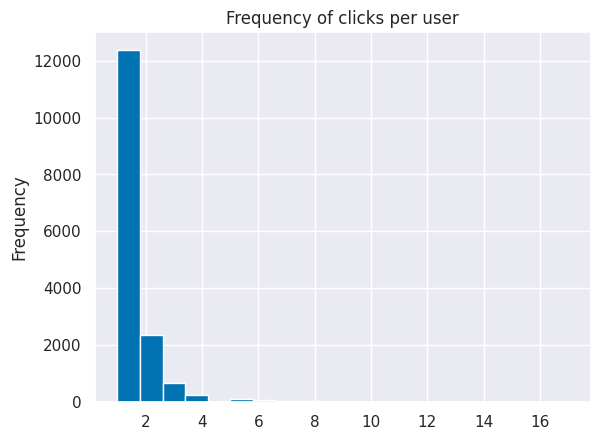

In [14]:
user_clicks_freq = clicks_df.groupby('user_id').size().sort_values(ascending = False)
user_clicks_freq.plot(kind = 'hist', bins = 20, title= 'Frequency of clicks per user');

In [15]:
print("Percentage of user who made more than one click: %.2f%%" % (sum(user_clicks_freq > 1)/len(user_clicks_freq) * 100))

Percentage of user who made more than one click: 21.90%


The current dataset has insufficient clicks per user to establish a reliable sequential feature, as only slightly more than 20% of users have more than one click. This limitation is primarily due to the data covering only a single week of user interactions. Nonetheless, I will proceed with creating sequential features, as these are expected to become more valuable when more extensive interaction data becomes available in the future.

In [16]:
# Function to create cumulative lists
def create_cumulative_list(items: pd.Series) -> list:
    cumulative_list = []
    result = []
    for item in items:
        result.append(cumulative_list.copy())
        cumulative_list.append(item)
    return result

# Function to create sequences
def create_sequence(tbl: pd.DataFrame, feature: str, fix_len: int = 5) -> pd.DataFrame:
    name = f"seq_{feature}"
    # Sort values by user_id and time and create list of value for each user
    tbl[name] = tbl.sort_values(by=['user_id', 'time']).groupby('user_id')[feature].transform(create_cumulative_list)
    # Pad sequences with zeros
    tbl[name] = tbl[name].apply(lambda x: (x + [0] * fix_len)[:fix_len])
    # Cast to string
    tbl[name] = tbl[name].apply(lambda x: [str(p) for p in x])

    return tbl

# Create sequences of product_id and category_name
clicks_df = create_sequence(clicks_df, 'product_id')
clicks_df = create_sequence(clicks_df, 'category_name')

assert clicks_df.shape[1] == data_df.shape[1] + 3, "Invalid Clicks dataset shape."

## Load to Tensorflow
I will separate the dataset into user and product features because we will using two towers in the retrieval model (query tower and item tower).  
Also, I split the features based on the feature type. This will be useful to vocabulary building and preprocessing.  
Next table summarizes the prefix with the feature type and preprocessing layer that will be used:

<div align="center">

| Prefix | Feature Type | Preprocessing Layer |
|--------|--------------|---------------------|
| cat- | Categorical | StringLookup |
| int- | Integer | IntegerLookup |
| text- | Text | StringLookup |
| cont- | Continuous | Normalization, Discretization |
| seq- | Sequential | StringLookup |

</div>

**Note**: If it doesn't have a prefix, then it won't be processed.

In [17]:
# Select features with transformation prefix separated by '-'
# cat stands for StringLookup, int for IntegerLookup, norm for Normalization and disc for Discretization layers.
# `time` won't be used in the model directly, but it will be used to calculate related time features
# `score` is the target variable to predict in ranking model
user_features = [
    'time',         
    'cat-user_id',
    'cat-channel',
    'cat-device_type',
    'text-query_text',
    'seq-seq_product_id',
    'seq-seq_category_name',
    'score',
    ]

product_features = [
    'cat-product_id',
    'cat-category_name',
    'cat-merchant_name',
    'cat-merchant_city',
    'cat-merchant_state',
    'cat-merchant_region',
    'int-free_shipping',
    'int-is_sold_out',
    'int-editor_pick',
    'int-on_sale',
    'text-product_name',
    'cont-sales_last_week', 
    'cont-sales_last_month', 
    'cont-sales_last_year',            
    'cont-price_in_cents',
    'cont-reviews',
]

# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

def create_dataset(data_df: pd.DataFrame, features: list) -> tf.data.Dataset:
    # Convert pandas dataframe to tensorflow dataset
    data_dict = {}
    # Sequential features has to be handled differently
    for f in features:
        f = f.split('-')[1] if '-' in f else f
        data_dict[f] = tf.constant(data_df[f].to_list(), dtype=tf.string) if f.startswith('seq_') else data_df[f]
    return tf.data.Dataset.from_tensor_slices(data_dict)

# Create datasets from the whole data to further vocabulary building
clicks = create_dataset(clicks_df, user_features + product_features)
products = create_dataset(products_df, product_features)

# Save products dataset to 'data' folder for further use
products.save(os.path.join('data','products'))

## Dataset Split

In [18]:
# Data length
n_data = clicks_df.shape[0]
# Train size
train_size = 0.8
train_samples = int(train_size * n_data)

# Split clicks dataset into train/val
y = clicks_df['score']
# Split without shuffling by the sequential features
clicks_train_df, clicks_val_df = train_test_split(clicks_df, test_size=1-train_size, random_state=42, shuffle=False)
# Ensure clicks are not shuffled
assert clicks_train_df['time'].is_monotonic_increasing and clicks_val_df['time'].is_monotonic_increasing, \
    "DataFrame is not ordered by timestamp in ascending order."
# Split with shuffling in case the sequential features won't be used, stratify to ensure target consistency among sets
clicks_train_df_sh, clicks_val_df_sh = train_test_split(clicks_df, test_size=1-train_size, random_state=42, stratify=y)

# Load as dataset
clicks_train = create_dataset(clicks_train_df, user_features + product_features)
clicks_val = create_dataset(clicks_val_df, user_features + product_features)
clicks_train_sh = create_dataset(clicks_train_df_sh, user_features + product_features)
clicks_val_sh = create_dataset(clicks_val_df_sh, user_features + product_features)

**NOTE**: I won't use *test set* because I want to have as much data as possible for training. I will use only 80% of data for training set and 20% for validation set.
In a real world scenario, I should have a test set to evaluate the model but I would have more data as well.

## Metadata

### Vocabulary
Create the vocabulary for each feature. `hour` and `day_of_week` are time related features that will be created from `time` feature.

In [19]:
# Define vocabulary for categorical features
VOCABULARY = {}
def set_vocabulary(features: list):
    # Add hour and day of the week vocabulary manually, since they are not in the dataset
    VOCABULARY['hour'] = np.arange(0, 24, dtype=np.int32)
    VOCABULARY['day_of_week'] = np.arange(0, 7, dtype=np.int32)

    for feature in features:
        feature = feature.split('-')[1]
        vocab = clicks.batch(512).map(lambda x: x[feature])
        VOCABULARY[feature] = np.unique(np.concatenate(list(vocab)))

# Only for categorical features (string and integer type)
cat_int_features = [f for f in user_features + product_features if f.startswith('cat-') or f.startswith('int-')]
set_vocabulary(cat_int_features)

assert len(VOCABULARY) == len(cat_int_features) + 2, "Invalid vocabulary size."


### Outliers
To reduce the impact of outliers on the model, I decide to dentify and clip outliers in continuous features by the following equation:

$$
Q_1 - 3 \cdot IQR \leq x \leq Q_3 + 3 \cdot IQR
$$
Where `Q1` and `Q3` are the first and third quartiles respectively, and `IQR` is the interquartile range given by:
$$ IQR = Q3 - Q1 $$

I will get the allowed boundaries for each continuous feature in `BOUNDARIES` dictionary. Then, I will clip the outliers within the model.

In [20]:
continuous_features = [f.split('-')[1] for f in user_features + product_features if f.startswith('cont-')]

def get_feature_range(df: pd.DataFrame, column: str) -> pd.DataFrame:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Define outlier boundaries
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    # Ensure that the lower bound is equal or over the miminum value allowed
    return (lower_bound if lower_bound >= df[column].min() else df[column].min(), upper_bound)

# Get continuous features boundaries metadata
BOUNDARIES = {}
for col in continuous_features:
    BOUNDARIES[col] = get_feature_range(data_df, col)

assert len(BOUNDARIES) == len(continuous_features), "Invalid boundaries size."

### Buckets

In [21]:
# Define buckets for continuous features
BUCKETS = {}

def set_buckets(features: list):
    for feature in features:
        feature = feature.split('-')[1]
        BUCKETS[feature] = np.linspace(BOUNDARIES[feature][0], BOUNDARIES[feature][1], num=100)

# Only for continuous features
set_buckets([f for f in user_features + product_features if f.startswith('cont-')])

assert len(BUCKETS) == len(continuous_features), "Invalid buckets size."

## Recommender Engine Model

The model architecture with all its components is shown below:  
<img src="data/baseline.png" alt="Model Architecture Overview" width="885" height="1644">

### Preprocessing Layer

I will encapsulate all preprocessing steps in a dedicated preprocessing layer. This layer can be called either within the model for streamlined integration or outside the model for flexible experimentation.  

**Function: `replace_empty_string`**
   - **Description**: Replaces empty strings in the input tensor with a placeholder value `[NULL]`.
   - **Arguments**: 
     - `x` (Tensor): Input tensor containing strings.
   - **Returns**: 
     - Tensor with empty strings replaced by `[NULL]`.

**Function: `extract_features`**
   - **Description**: Extracts time-based features such as the hour and day of the week from a timestamp in the input using Zellers Congruence.
   - **Arguments**: 
     - `x` (dict[tf.Tensor]): A dictionary containing a `'time'` field with string-based timestamps.
   - **Returns**: 
     - A dictionary with additional fields for the hour and the day of the week, calculated using the timestamp.

**Function: `clip_cont_features`**
   - **Description**: Clip continuous features to be within their respective boundaries and prefix them with `clip_`.
   - **Arguments**: 
     - `x` (dict[tf.Tensor]): A dictionary of input features.
     - `features` (list[str]): List of features to be included in the model.
   - **Returns**: 
     - A dictionary of original and clipped features. Last with `clip_` prefix added.

**Class: `Preprocessing`**
   - **Description**: A custom Keras preprocessing layer designed to handle various types of preprocessing tasks such as categorical encoding, integer mapping, text vectorization, discretization, and normalization.
   
   - **Attributes**:
     - `features` (list[str]): List of features to be preprocessed, with their types indicated (e.g., `cat-feature`, `int-feature`).
     - `prep_layers` (dict): Dictionary containing the preprocessing layers for each feature based on the feature type.
     - `extract_time_features` (optional): Lambda layer for extracting time-based features like hour and day of the week.
     - `clip_outliers` (optional): Lambda layer for clipping outliers.

**Preprocessing Types**:
   - **Categorical (`cat-`)**: Uses `StringLookup` to map string-based categorical data to integer indices.
   - **Integer (`int-`)**: Uses `IntegerLookup` to map integer-based data to indices.
   - **Text (`text-`)**: Uses `TextVectorization` for tokenizing text into integer sequences. Includes handling of empty strings.
   - **Discretization (`disc-`)**: Uses `Discretization` to bin continuous values into predefined intervals.
   - **Normalization (`norm-`)**: Uses `Normalization` to standardize numerical values based on the dataset.
   - **Sequence (`seq-`)**: Uses `StringLookup` to map sequences of categorical data into integer indices.

In [22]:
@tf.function
def replace_empty_string(x: tf.Tensor) -> tf.Tensor:
    """
    Replace empty strings in a feature with '[NULL]'

    Parameters
    ----------
    x : tf.Tensor
        Feature to be processed

    Returns
    -------
    tf.Tensor
        Processed feature
    """
    return tf.where(tf.strings.regex_full_match(x, ""), tf.constant("[NULL]"), x)

@tf.function
def extract_features(x: dict[tf.Tensor]) -> dict[tf.Tensor]:
    """
    Extracts time-based features such as the hour and day of the week from a timestamp in the input using Zellers Congruence.

    Parameters
    ----------
    x : dict[tf.Tensor]
        Dictionary of input features

    Returns
    -------
    dict[tf.Tensor]
        Dictionary of processed features
    """
    # Extract the 'time' feature
    times = x['time']

    # Extract date and time parts using substr
    date_str = tf.strings.substr(times, 0, 10)
    time_str = tf.strings.substr(times, 11, 12)

    # Extract date components
    years = tf.strings.to_number(tf.strings.substr(date_str, 0, 4), tf.int32)
    months = tf.strings.to_number(tf.strings.substr(date_str, 5, 2), tf.int32)
    days = tf.strings.to_number(tf.strings.substr(date_str, 8, 2), tf.int32)

    # Extract hour
    hours = tf.strings.to_number(tf.strings.substr(time_str, 0, 2), tf.int32)

    # Helper function to calculate day of week using Zeller's Congruence
    def zellers_congruence(year, month, day):
        if month < 3:
            month += 12
            year -= 1
        K = year % 100
        J = year // 100
        f = day + ((13 * (month + 1)) // 5) + K + (K // 4) + (J // 4) + (5 * J)
        return (f % 7 + 5) % 7 # Shift the output to have Monday as 0, Tuesday as 1, ...

    # Calculate the day of the week
    day_of_week = tf.vectorized_map(lambda x: zellers_congruence(x[0], x[1], x[2]), (years, months, days))

    # Add the parsed components back to the dictionary
    return {**x, 'hour': hours, 'day_of_week': day_of_week}

@tf.function
def clip_cont_features(x: dict[tf.Tensor], features: list[str]) -> dict[tf.Tensor]:
    """
    Clip continuous features to their respective boundaries.

    Parameters
    ----------
    x : dict[tf.Tensor]
        Dictionary of input features
    features: list[str]
        List of features to be included in the model

    Returns
    -------
    dict[tf.Tensor]
        Dictionary of clipped features
    """
    clipped_features = {}
    for feature in x:
        # Clip features in BOUNDARIES and avoid redundancy when the same feature is mapped as norm and disc
        if feature in BOUNDARIES.keys() and f"clip_{feature}" not in clipped_features.keys():
            clipped_features[f"clip_{feature}"] = tf.clip_by_value(x[feature], BOUNDARIES[feature][0], BOUNDARIES[feature][1])
    # Add the generated clipped features to the input
    return {**x, **clipped_features}


@tf.keras.saving.register_keras_serializable(package="RecommendationEngine", name="PreprocessingLayer")
class Preprocessing(tf.keras.layers.Layer):
  
    def __init__(self, name: str, features: list[str], ds: tf.data.Dataset= None):
        """
        A custom Keras preprocessing layer designed to handle various types of preprocessing tasks such as categorical encoding, integer mapping, text vectorization, discretization, and normalization.

        Parameters
        ----------
        name : str
            Name of the layer
        features : list[str]
            List of features to be processed
        ds : tf.data.Dataset, optional
            Dataset where the features come from (clicks or products), by default None
        """
        super().__init__(name=name)
        
        self.features = features
        self.prep_layers = {}
        self._adaptables: dict = {}

        self.extract_time_features = None
        if "int-hour" in self.features or "int-day_of_week" in self.features:
            self.extract_time_features = tf.keras.layers.Lambda(extract_features, name= "extract_time_features")

        self.clip_outliers = None
        if any(f.startswith('disc-') or f.startswith('norm-') for f in self.features):
            self.clip_outliers = tf.keras.layers.Lambda(clip_cont_features, name= "clip_outliers", arguments={"features": self.features})

        for feature in self.features:
            if '-' not in feature:
                continue

            prep, feat = feature.split("-")
            if prep == "cat":
                vocab: list[str] = VOCABULARY[feat]
                self.prep_layers[feature] = tf.keras.layers.StringLookup(vocabulary=vocab, mask_token=None, name=feature)

            elif prep == "int":
                vocab: list[str] = VOCABULARY[feat]
                self.prep_layers[feature] = tf.keras.layers.IntegerLookup(vocabulary=vocab, mask_token=None, name=feature)
                
            elif prep == "text":
                text_layer = tf.keras.layers.TextVectorization(
                        max_tokens = 10_000,
                        output_mode="int",
                        output_sequence_length=20,
                        name=f"tv_{feature}"
                    )
                text_layer.adapt(ds.map(lambda x: x[feat]))
                self.prep_layers[feature] = tf.keras.Sequential([
                    tf.keras.layers.Lambda(replace_empty_string, name= f"text_null_{feature}"),
                    text_layer
                ], name=feature)

            elif prep == "disc":
                buckets: list[float] = BUCKETS[feat]
                # Need to add clip before var name in order to use the clipped features rather than the original ones
                self.prep_layers[f"disc-clip_{feat}"] = tf.keras.layers.Discretization(buckets.tolist(), name=feature)
            
            elif prep == "norm":
                norm_layer = tf.keras.layers.Normalization(axis = None, name=feature)
                norm_layer.adapt(ds.map(lambda x: x[feat]))
                self.prep_layers[f"norm-clip_{feat}"] = norm_layer

            elif prep == "seq":
                vocab: list[str] = VOCABULARY[feat.replace("seq_", "")]
                self.prep_layers[feature] = tf.keras.layers.StringLookup(vocabulary=vocab, mask_token=None, name=feature)
            
            else:
                raise ValueError("Preprocessing type not supported.")

    def call(self, input: dict[str, tf.Tensor]):
        # Extract time features and add them if needed
        if self.extract_time_features:
            input = self.extract_time_features(input)
        # Clip outliers in continuous features if they are present
        if self.clip_outliers:
            input = self.clip_outliers(input)
        output = {feature: layer(input[feature.split("-")[1]]) for feature, layer in self.prep_layers.items()}
        return {**input, **output}
    
    def get_config(self):
        # Method needed for serialization and saving
        config = super().get_config()
        config.update({
            'features': self.features,
            # Do not include 'ds' as it is not needed for serialization
        })
        return config


### Embedding Layer

**Class: `Embeddings`**
   - **Description**: A custom Keras layer designed to handle embedding generation for various types of features. The layer manages multiple embeddings and concatenates them to create a feature representation.
   
   - **Attributes**:
     - `params` (dict[str, Any]): Dictionary containing parameters for feature embedding and model configuration.
     - `features` (list[str]): List of features from the `params` dictionary that require embeddings.
     - `emb_weight` (float): Weight used to scale the embedding dimensions.
     - `embeddings` (dict): Dictionary storing the embedding layers for each feature.
     - `output_dim` (int): Tracks the total output dimension across all embedding layers.

**Embedding Types**:
   - **Categorical (`cat-`) and Integer (`int-`)**: Creates an embedding layer for categorical and integer features, input dimension given by the vocabulary size.
   - **Text (`text-`)**: Generates an embedding layer for text features, followed by a `GlobalAveragePooling1D` layer to compute the average of the embedded sequence.
   - **Discretized (`disc-`)**: Creates an embedding layer for discretized features, where the input dimension is determined by the number of buckets.
   - **Normalized (`norm-`)**: Normalizated features are reshaped and added at the end of the embedding.
   - **Sequence (`seq-`)**: Creates an embedding layer for sequence-based features, followed by a `GRU` layer to capture sequential dependencies in the data.

**Function: `get_embedding`**
   - **Description**: Computes the embedding dimension using the following formula:        
        $\begin{align}
            \text{emb\_dim} =  \text{emb\_weight} * (\log_2(\text{input\_dim}) + 1)
        \end{align}$
        It also creates the embedding layer for the feature.
   - **Parameters**:
     - `feature` (str): Name of the feature being embedded.
     - `input_dim` (int): The size of the input dimension (usually based on the vocabulary size or number of buckets).
   - **Returns**:
     - `emb_dim` (int): Calculated embedding dimension.
     - `embedding` (Layer): The Keras embedding layer for the feature.

In [23]:
@tf.keras.saving.register_keras_serializable(package="RecommendationEngine", name="EmbeddingsLayer")
class Embeddings(tf.keras.layers.Layer):

    def __init__(self, name: str, params: dict[str, Any]):
        """
        A custom Keras layer designed to handle embedding generation for various types of features.
        The layer manages multiple embeddings and concatenates them to create a feature representation.

        Parameters
        ----------
        name : str
            Name of the layer
        params : dict[str, Any]
            Dictionary of layer parameters
        """
        super().__init__(name= name)

        self.params = params
        
        l_name = name.replace("Embeddings", "").lower()
        self.features = params['FEATURES'][l_name.upper()]
        self.emb_weight = params['MODEL'].get('emb_weight', 1)
        
        self.embeddings = {}
        self.output_dim = 0

        for feature in self.features:
            if '-' not in feature:
                continue
            
            prep, feat = feature.split("-")
            if prep in ["cat", "int"]:
                input_dim = len(VOCABULARY[feat])
                emb_dim, embedding = self.get_embedding(feature, input_dim)
                self.embeddings[feature] = embedding
                
            elif prep == "text":
                input_dim = 10_000
                emb_dim, embedding = self.get_embedding(feature, input_dim)
                self.embeddings[feature] = tf.keras.Sequential([
                    embedding,
                    tf.keras.layers.GlobalAveragePooling1D(name= f"text_avg_{feature}"),
                ])
            
            elif prep == "disc":
                input_dim = len(BUCKETS[feat])
                emb_dim, embedding = self.get_embedding(feature, input_dim)
                self.embeddings[f"disc-clip_{feat}"] = embedding

            elif prep == "seq":
                input_dim = len(VOCABULARY[feat.replace("seq_", "")])
                emb_dim, embedding = self.get_embedding(feature, input_dim)
                self.embeddings[feature] = tf.keras.Sequential([
                    embedding,
                    tf.keras.layers.GRU(emb_dim, name=f"seq_gru_{feature}"),
                ])
    
    def get_embedding(self, feature: str, input_dim: int) -> tuple[int, tf.keras.layers.Layer]:
        """
        Generate an embedding layer for the given feature

        Parameters
        ----------
        feature : str
            Name of the feature
        input_dim : int
            Input dimension of the embedding layer

        Returns
        -------
        int
            Embedding dimension
        tf.keras.layers.Layer
            Embedding layer
        """
        emb_dim = int((np.log2(input_dim) + 1) * self.emb_weight)
        self.output_dim += emb_dim
        return emb_dim, tf.keras.layers.Embedding(input_dim + 1, emb_dim, name=f"emb_{feature}", mask_zero=feature.split("-")[0] == "text")

    def call(self, input: dict[str, tf.Tensor]):
        # Add normalized features as they are because they don't need embeddings. Only reshape is needed.
        normalized_features = [tf.reshape(input[f"norm-clip_{f.split('-')[1]}"], (-1, 1)) for f in self.features if f.split("-")[0] == "norm"]
        # Concat embeddings and normalized features
        return tf.concat([self.embeddings[feature](input[feature]) for feature in self.embeddings.keys()] + normalized_features, axis=1)

    def get_config(self):
        # Method needed for serialization and saving
        config = super().get_config()
        config.update({
            'params': self.params
        })
        return config


### Deep Layers Model

**Class: `DeepLayers`**
   - **Description**: A custom Keras model representing a deep neural network with optional cross-layer functionality. This layer is designed to build a stack of dense layers with ReLU activation and include dropout for regularization.

   - **Attributes**:
     - `model_params` (dict[str, Any]): Dictionary containing the model configuration, including layer sizes, dropout rate, and whether to use cross layers.
     - `deep_layers` (list[int]): A list of integers specifying the number of units for each dense layer in the deep network.
     - `model` (tf.keras.Sequential): A Keras sequential model that holds the deep layers and optional cross layer for the deep neural network.

**Deep Layers Construction**:
   - **Cross Layer**: If the `cross_layer` flag in `model_params` is set to `True`, a `tfrs.layers.dcn.Cross` layer is added to the model. This layer uses a projection dimension of one-quarter of the embedding dimension (`input_dim // 4`) to reduce computational cost while maintaining accuracy.
   - **ReLU Activation**: For each hidden layer (except the last one), a `Dense` layer with ReLU activation is created. This ensures non-linearity in the model.
   - **Dropout Regularization**: Dropout layers are added after each hidden layer to prevent overfitting. The dropout rate is specified in the `model_params`.
   - **Output Layer**: The last dense layer has no activation function, allowing the network to output raw values for further processing or loss computation.


In [24]:
@tf.keras.saving.register_keras_serializable(package="RecommendationEngine", name="DeepLayers")
class DeepLayers(tf.keras.Model):
    def __init__(self, name: str, model_params: dict[str, Any], input_dim: int):
        """
        A custom Keras model representing a deep neural network with optional cross-layer functionality. 
        This layer is designed to build a stack of dense layers with ReLU activation and include dropout for regularization.

        Parameters
        ----------
        name : str
            Name of the layer
        model_params : dict[str, Any]
            Dictionary of model parameters
        input_dim : int
            Input dimension
        """
        super().__init__(name= name)

        self.model_params = model_params
        l_name = re.sub(r"Tower|Model", "", name).lower()
        self.deep_layers = model_params[f"{l_name}_layers"]
        self.model = tf.keras.Sequential(name=f"{l_name}_deep_layers")

        if model_params["cross_layer"]:
            # Note that projection_dim needs to be smaller than (input size)/2 to reduce the cost. 
            # In practice, it've been observed using low-rank DCN with rank (input size)/4 consistently preserved the accuracy of a full-rank DCN.
            self.model.add(tfrs.layers.dcn.Cross(projection_dim=input_dim // 4, kernel_initializer="glorot_uniform", name=f"cross_{l_name}"))

        # Use the ReLU activation for all but the last layer.
        for i, layer_size in enumerate(self.deep_layers[:-1]):
            self.model.add(tf.keras.layers.Dense(layer_size, activation="relu", name=f"{l_name}_layer{i:02d}"))

            # Add dropout layer for regularization after each layer except between the last two layers
            if i != len(self.deep_layers) - 1:                
                self.model.add(tf.keras.layers.Dropout(model_params["dropout"], name=f"{l_name}_dropout{i:02d}"))

        # No activation for the output layer.
        self.model.add(tf.keras.layers.Dense(self.deep_layers[-1], name=f"{l_name}_output_layer"))
        
    def call(self, input: tf.Tensor):
        return self.model(input)
    
    def get_config(self):
        # Method needed for serialization and saving
        config = super().get_config()
        config.update({
            'model_params': self.model_params
        })
        return config


### Model

**Class: `RecommenderEngineModel`**
   - **Description**: A custom recommendation model built on top of TensorFlow Recommenders (TFRS) framework. This model implements a dual-tower architecture for learning user (query) and product (candidate) embeddings. It supports both retrieval (matching users to products) and ranking tasks (predicting user ratings for products). Optionally, it handles input feature preprocessing, which is disabled during the experimentation workflow and enabled during serving.

   - **Attributes**:
     - `params` (dict[str, Any]): Dictionary containing model parameters, including layer configurations and feature definitions.
     - `train_metrics` (bool): A flag indicating whether training metrics are enabled.
     - `preprocessing` (bool): A flag indicating whether preprocessing is applied to the input data before feeding it into the model.
     - `user_prep` (Preprocessing): Preprocessing layer for the user data, if preprocessing is enabled.
     - `prods_prep` (Preprocessing): Preprocessing layer for the product data, if preprocessing is enabled.
     - `user_embedding` (tf.Tensor): Embedding layer for the user data.
     - `user_model` (DeepLayers): Deep neural network applied to the user embeddings.
     - `product_embedding` (tf.Tensor): Embedding layer for the product data (candidate items).
     - `product_model` (DeepLayers): Deep neural network applied to the product embeddings.
     - `rating_model` (DeepLayers): Deep network that predicts the rating based on concatenated user and product embeddings.
     - `candidates_model` (tf.keras.Sequential): Sequential model combining product preprocessing, embedding, and deep network layers to generate candidate embeddings for the retrieval task.
     - `retrieval_task` (tfrs.tasks.Retrieval): Task for computing the loss and metrics for the retrieval problem (matching queries to products).
     - `rating_task` (tfrs.tasks.Ranking): Task for computing the loss and metrics for the ranking problem (predicting user ratings for products).

**Model Architecture**:
   - **Preprocessing (Optional)**: If `preprocessing=True`, the model applies a preprocessing step to both user and product data using the `Preprocessing` class. The preprocessing logic is customized for both queries (users) and products (items).
   - **user and Product Embeddings**: 
     - Both queries and products are passed through their respective embedding layers (`user_embedding` and `product_embedding`) using the `Embeddings` class. These embeddings map raw features to dense vector representations.
   - **Deep Neural Networks**: 
     - Two separate deep neural networks (`DeepLayers`) are used for queries and products. These networks process the embeddings to produce final representations that are used in both retrieval and ranking tasks. Note that the output dimensions of these deep neural networks have to be the same for the retrieval task.
     - One fully connected network (`DeepLayers`) is used for the rating prediction task.
   - **Dual-Tower Retrieval Task**: The model uses a dual-tower architecture for the retrieval task, where both user and product representations are learned separately and then used for matching. The product embeddings are stored and later retrieved during inference.
   - **Rating Prediction (Ranking Task)**: The model concatenates the user and product embeddings to predict a user rating, with the output layer having a single unit (as defined by the model's assertions).
   
**Method: `call`**
   - **Description**: Defines the forward pass for the model. Depending on whether preprocessing is applied, the input is processed accordingly. The user and product embeddings are passed through their respective deep models, and the rating is computed by concatenating the two embeddings.

**Method: `compute_loss`**
   - **Description**: Computes the total loss by summing the losses for both retrieval and ranking tasks. The retrieval loss is computed by matching user embeddings with product embeddings, while the ranking loss is based on the predicted user ratings.

**Model Tasks**:
   - **Retrieval Task**: Implements a candidate retrieval task using `tfrs.tasks.Retrieval`. The task computes the retrieval loss and evaluates the performance using the `FactorizedTopK` metric, which ranks items based on their relevance to a user.
   - **Ranking Task**: Implements a ranking task using `tfrs.tasks.Ranking`. The task computes the loss using mean squared error (MSE) between the predicted and actual ratings and evaluates it using root mean squared error (RMSE). 

In [25]:
class RecommenderEngineModel(tfrs.models.Model):

    def __init__(self, params: dict[str, Any], preprocessing: bool = None, candidates: tf.data.Dataset = None, train_metrics: bool = False):
        """
        A custom recommendation model built on top of TensorFlow Recommenders (TFRS) framework.
        This model implements a dual-tower architecture for learning user (query) and product (candidate) embeddings.
        It supports both retrieval (matching users to products) and ranking tasks (predicting user ratings for products). 
        Optionally, it handles input feature preprocessing, which is disabled during the experimentation workflow and enabled during serving.

        Parameters
        ----------
        params : dict[str, Any]
            Dictionary of model parameters
        preprocessing : bool, optional
            Whether to apply preprocessing. Default is False
        candidates : tf.data.Dataset
            Preprocessed Products dataset.
        train_metrics : bool, optional
            Whether to enable training metrics. Default is False
        """
        super().__init__()

        self.params = params
        self.train_metrics = train_metrics

        # If preprocessing is required
        self.preprocessing = preprocessing
        if self.preprocessing:
            self.user_prep = Preprocessing(
                "UserPreprocessing", params['FEATURES']['USER'], 
                clicks.batch(512).cache().prefetch(tf.data.AUTOTUNE)
            )
            self.prods_prep = Preprocessing(
                "ProductsPreprocessing", params['FEATURES']['PRODUCT'], 
                products.batch(512).cache().prefetch(tf.data.AUTOTUNE)
            )

        # Input Deep Layers verification
        assert params['MODEL']['user_layers'][-1] == params['MODEL']['product_layers'][-1], "User and Product output layers must have the same dimension"
        assert params['MODEL']['rating_layers'][-1] == 1, "Rating output layer must have 1 unit"

        # QUERY
        self.user_embedding: tf.Tensor = Embeddings('UserEmbeddings', params)
        self.user_model = DeepLayers('UserTower', params['MODEL'], self.user_embedding.output_dim)
        
        # PRODUCT
        self.product_embedding: tf.Tensor = Embeddings('ProductEmbeddings', params)
        self.product_model = DeepLayers('ProductTower', params['MODEL'], self.product_embedding.output_dim)
                
        # RATING
        self.rating_model: tf.Tensor = DeepLayers(
            'RatingModel', 
            params['MODEL'], 
            self.user_embedding.output_dim + self.product_embedding.output_dim
        )

        # TASKS
        # Retrieval Task
        # Build the candidates model to be used as candidates.
        self.candidates_model = tf.keras.Sequential(name="product_candidates")
        self.candidates_model.add(self.product_embedding)
        self.candidates_model.add(self.product_model)

        self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                # candidates here is the preprocessed version of products
                candidates.batch(512).cache().prefetch(tf.data.AUTOTUNE).map(self.candidates_model, num_parallel_calls=tf.data.AUTOTUNE)
            )
        )

        # Ranking Task
        self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )

    def call(self, input: dict[str, tf.Tensor]):
        # Make feature preprocessing if required
        if self.preprocessing:
            user_prep_data = self.user_prep(input)
            prods_prep_data = self.prods_prep(input)
            input = {**user_prep_data, **prods_prep_data}

        # Get embeddings
        user_embedding: tf.Tensor = self.user_embedding(input)
        product_embedding: tf.Tensor = self.product_embedding(input)

        # Get model outputs
        return (
            self.user_model(user_embedding),
            self.product_model(product_embedding),
            self.rating_model(tf.concat([user_embedding, product_embedding], axis=1))
        )

    def compute_loss(self, input: dict[str, tf.Tensor], training=False):
        ratings: tf.Tensor = input.pop("score")

        user, product, rating = self(input)

        compute_metrics = True if self.train_metrics else not training
        # We compute the loss for each task.
        rating_loss = self.rating_task(
            labels=ratings,
            predictions=rating,
            compute_metrics=compute_metrics
        )
        retrieval_loss = self.retrieval_task(user, product, compute_metrics=compute_metrics)

        # And sum up the losses
        return (rating_loss + retrieval_loss)
    
    def get_config(self):
        # Method needed for serialization and saving
        config = super().get_config()
        config.update({
            'params': self.params,
            'preprocessing': self.preprocessing
        })
        return config


## Parameters

In [26]:
LOGPATH = 'logs'

PARAMETERS = {
    "FEATURES": {
        'USER': [
            'time',         
            'cat-user_id',
            'cat-channel',
            'cat-device_type',
            'int-hour',
            'int-day_of_week',   
            'text-query_text',
            'seq-seq_product_id',
            'seq-seq_category_name',
            'score',
            ],
        'PRODUCT': [
            'cat-product_id',
            'cat-category_name',
            'cat-merchant_name',
            'cat-merchant_city',
            'cat-merchant_state',
            'cat-merchant_region',
            'int-free_shipping',
            'int-is_sold_out',
            'int-editor_pick',
            'int-on_sale',
            'text-product_name',
            'disc-sales_last_week', 
            'disc-sales_last_month', 
            'disc-sales_last_year',
            'disc-price_in_cents',
            'disc-reviews',
            'norm-sales_last_week', 
            'norm-sales_last_month', 
            'norm-sales_last_year',            
            'norm-price_in_cents',
            'norm-reviews',
        ]
    },
    "MAX_EPOCHS": 300,
    "BATCH_SIZE": 128,
    "EARLY_STOPPING": {
        "patience": 3,
        "start_from_epoch": 5,
        "delta_retrieval": 0.01, 
        "delta_rating": 0.01, 
        # I'll focus on top 50 because is unlikely a user will show more than 50 products
        "retrieval_metric": "val_factorized_top_k/top_50_categorical_accuracy",
        "rating_metric": "val_root_mean_squared_error"
    },
    "LEARNING_RATE": {
        "initial_learning_rate": 0.1, # starting from 0.1 further decay until early stopping is reached
        # In order to decay two orders of magnitude in 8 (start_from_epoch + patience) epochs from 0.1 to 0.001 (plot in next cell)
        "decay_rate": 0.57,
        "staircase": True
    },
    # Baseline Model Hyperparameters
    'MODEL': {
        # embedding weight shared among all features where emb_size = (np.log2(input_dim) + 1) * emb_weigh
        'emb_weight': 8,
        # note that this model doesn't have deep layers defined, only a dense layer to ensure same output size among the towers
        'user_layers': [32],
        'product_layers': [32],
        # rating model need one unit as output for regression
        'rating_layers': [64, 32, 1],
        'dropout': 0.1,
        # disable cross layer to keep it simple
        'cross_layer': False,
        'optimizer': 'Adagrad'
    }
}

## LR schedule

I will set the LR schedule to decay two orders of magnitude (from 0,1 to 0,001) in 8 (start_from_epoch + patience) epochs. That's the minimum number of epochs required for early stopping.

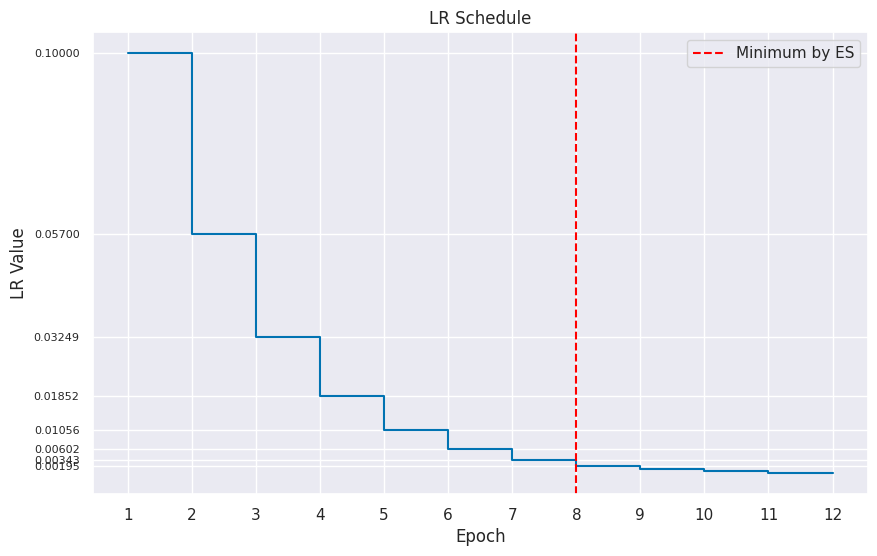

In [27]:
# Epochs to display
n = 12
# Minimum number of epochs needed by Early Stopping schedule
min_early_stopping = PARAMETERS['EARLY_STOPPING']['start_from_epoch'] + PARAMETERS['EARLY_STOPPING']['patience']
# Number of steps within a epoch given the batch size
n_steps = np.ceil(train_samples / PARAMETERS["BATCH_SIZE"])
# Set the decay_steps argument to the number of steps in a epoch
PARAMETERS['LEARNING_RATE']['decay_steps'] = n_steps

# Set up Exponential scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(**PARAMETERS['LEARNING_RATE'])

# Compute LR schedule
lr_values = [lr_schedule(i * n_steps).numpy() for i in range(n)]

# Plot LR schedule
fig = plt.figure(figsize=(10, 6))
plt.step(x=range(1, n + 1), y=lr_values, where="post")
plt.axvline(x=min_early_stopping, color='red', linestyle='--', label='Minimum by ES')
plt.xlabel('Epoch')
plt.ylabel('LR Value')
plt.xticks(range(1, n + 1))
plt.yticks(lr_values[:8], fontsize= 8)
plt.title('LR Schedule')
plt.legend()
plt.show()

## Dataset Preprocessing

To avoid repeteadly preprocessing the input data each time we train the model I'll preprocess the data before training and turn off the preprocessing step with `preprocessing=False` argument.

In [28]:
# Create preprocessing layers instances
user_prep = Preprocessing(name="UserPreprocessing", features=PARAMETERS['FEATURES']['USER'], ds=clicks.batch(512))
product_prep = Preprocessing(name="ProductPreprocessing", features=PARAMETERS['FEATURES']['PRODUCT'], ds=products.batch(512))
# Preprocess the entire clicks and products datasets
prep_clicks = clicks.batch(512).map(user_prep).map(product_prep).unbatch()
prep_products = products.batch(512).map(product_prep).unbatch()
# Preprocess the train and val datasets
prep_clicks_train = clicks_train.batch(512).map(user_prep).map(product_prep).unbatch()
prep_clicks_val = clicks_val.batch(512).map(user_prep).map(product_prep).unbatch()
# Preprocess the train and val shuffled datasets
prep_clicks_train_sh = clicks_train_sh.batch(512).map(user_prep).map(product_prep).unbatch()
prep_clicks_val_sh = clicks_val_sh.batch(512).map(user_prep).map(product_prep).unbatch()

## Train Pipeline

In [29]:
# Custom Early Stopping
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(
            self, patience=0, start_from_epoch=0, 
            delta_retrieval=0.01, delta_rating=0.01,
            retrieval_metric: str = "val_factorized_top_k/top_50_categorical_accuracy",
            rating_metric: str = "val_root_mean_squared_error"
        ):
        """
        A custom early stopping callback for Keras models, which monitors both retrieval and rating metrics
        during training. The callback stops the training process if no improvements are observed in the specified 
        metrics within the defined patience period, starting from a given epoch.

        Parameters
        ----------
        patience : int
            Number of epochs with no improvement after which training will be stopped. Default is 0.
        start_from_epoch : int
            The epoch number from which to start monitoring the metrics for early stopping. Default is 0.
        delta_retrieval : float
            Minimum change in the retrieval metric to qualify as an improvement. Default is 0.01.
        delta_rating : float
            Minimum change in the rating metric to qualify as an improvement. Default is 0.01.
        retrieval_metric : str, optional
            The name of the retrieval metric to monitor. Default is "val_factorized_top_k/top_50_categorical_accuracy".
        rating_metric : str, optional
            The name of the rating metric to monitor. Default is "val_root_mean_squared_error".
        """
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.start_from_epoch = start_from_epoch
        self.delta_retrieval = delta_retrieval
        self.delta_rating = delta_rating
        self.retrieval_metric = retrieval_metric
        self.rating_metric = rating_metric

    def on_train_begin(self, logs=None):
        self.wait = 0
        self.retrieval_metric_value = -np.Inf
        self.rating_metric_value = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current_retrieval_metric = logs.get(self.retrieval_metric)
        current_rating_metric = logs.get(self.rating_metric)
        improvement = False

        if epoch < self.start_from_epoch or current_retrieval_metric is None or current_rating_metric is None:
            return

        # Check for improvement in the retrieval metric
        if current_retrieval_metric is not None and np.greater(current_retrieval_metric - self.retrieval_metric_value, self.delta_retrieval):
            self.retrieval_metric_value = current_retrieval_metric
            self.wait = 0
            improvement = True

        # Check for improvement in the rating metric
        if current_rating_metric is not None and np.less(current_rating_metric - self.rating_metric_value, -self.delta_rating):
            self.rating_metric_value = current_rating_metric
            self.wait = 0
            improvement = True

        # If no improvement is observed, increase the wait counter and stop training if patience is exceeded
        if not improvement:
            self.wait += 1
            if self.wait >= self.patience and epoch >= self.start_from_epoch:
                self.model.stop_training = True

# Training Function
def train_model(
        train: tf.data.Dataset, 
        val: tf.data.Dataset = None,
        preprocessing: bool = False, 
        params: dict = None,
        train_metrics: bool = False,
        logging: bool = False,
        profile: tuple | int = 0,
        verbose: int = 1
    ) -> RecommenderEngineModel:
    """
    Trains a custom recommendation model using TensorFlow's training framework. The function configures the model based on given parameters, 
    and optionally enables logging and profiling.

    Parameters
    ----------
    train : tf.data.Dataset
        The training dataset.
    val : tf.data.Dataset, optional
        The validation dataset. Default is None.
    preprocessing : bool, optional
        Whether to apply preprocessing to the input datasets. Default is False.
    params : dict, optional
        Dictionary containing model parameters, including early stopping, learning rate schedule, and batch size.
    train_metrics : bool, optional
        Whether to enable training metrics. Default is False.
    logging : bool, optional
        If True, TensorBoard logging is enabled, and model parameters are saved to a log directory. Default is True.
    profile : tuple or int, optional
        Batch to profile in TensorBoard for performance tracking. Default is 0 (no profiling).
    verbose : int, optional
        Verbosity level for model training. Default is 1.

    Returns
    -------
    model : RecommenderEngineModel
        The trained recommendation model instance.
    """

    # Setup Early Stopping and TerminateOnNaN callbacks
    callbacks = [CustomEarlyStopping(**params['EARLY_STOPPING']), tf.keras.callbacks.TerminateOnNaN()]
    
    # Setup learning rate scheduler with exponential decay
    n_steps = np.ceil(train_samples / params.get("BATCH_SIZE", 1024))
    params['LEARNING_RATE']['decay_steps'] = n_steps # decay after each epoch
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(**params['LEARNING_RATE'])    

    # Optionally enable TensorBoard logging
    if logging:
        logdir = params.get("LOGDIR", "logs")
        # Create a file writer for the log directory
        file_writer = tf.summary.create_file_writer(logdir)
        
        # Write model parameters to log directory
        model_metadata = json.dumps(params, indent=4)
        with file_writer.as_default():
            tf.summary.text(f"Parameters for {logdir}:", f"```\n{model_metadata}\n```", step=0)

        # Add TensorBoard callback for logging and profiling
        callbacks.append(tf.keras.callbacks.TensorBoard(logdir, profile_batch=profile))

    # Create the RecommenderEngineModel instance
    model = RecommenderEngineModel(params, preprocessing=preprocessing, candidates= prep_products, train_metrics=train_metrics)

    # Choose and configure the optimizer
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=lr_schedule)
    if params["MODEL"]["optimizer"] == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    
    # Compile the model
    model.compile(optimizer=optimizer)
    
    # Batch, cache, and prefetch the datasets for optimized loading during training
    train = train.cache().repeat().batch(params.get("BATCH_SIZE", 1024)).prefetch(tf.data.AUTOTUNE)
    if val:
        val = val.cache().repeat().batch(512).prefetch(tf.data.AUTOTUNE)

    # Fit the model to the training data, with validation on the validation set
    model.fit(
        train,
        epochs=params.get("MAX_EPOCHS", 10),
        validation_data=val,
        callbacks=callbacks,
        steps_per_epoch=n_steps,
        validation_steps=np.ceil((n_data - train_samples) / 512),
        verbose=verbose
    )

    return model

### KFold Cross Validation function

In [30]:
def train_CV(params: dict):
    base_path = params['LOGDIR']
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = []
    for fold, (train_index, val_index) in tqdm(enumerate(kf.split(clicks_df)), total=n_splits, desc='Cross Validation', unit='fold'):
        params['LOGDIR'] = os.path.join(base_path, f"fold_{fold}")
        train_df = clicks_df.iloc[train_index]
        val_df = clicks_df.iloc[val_index]

        # Convert to TF Dataset
        train_ds = create_dataset(train_df, user_features + product_features)
        val_ds = create_dataset(val_df, user_features + product_features)

        # Train the model
        model = train_model(
            train= train_ds,
            val= val_ds,
            preprocessing= True, 
            params= params,
            logging= True,
            verbose= 0
        )

        # Get metrics
        result = {m: v[-1] for m, v in model.history.history.items() if m.startswith('val')}
        result['fold'] = fold
        result['n_epochs'] = len(model.history.history['loss'])
        results.append(result)

    return pd.DataFrame(results)

## Experimentation

### Baseline Model
The model selected to perform this analysis will be a baseline model that is as simple as possible to avoid overfitting, but complex enough that it doesn't fall into underfitting. I can't use KFold CV because the sequential features require to have the data ordered by timestamp.

In [33]:
def train_baseline():
    params = copy.deepcopy(PARAMETERS)
    params['LOGDIR'] = os.path.join(LOGPATH, 'baseline')

    return train_model(
        train= clicks_train,
        val= clicks_val,
        preprocessing= True,
        params= params,
        train_metrics= True, # Turn on training metrics
        logging= True,
        profile= (20, 25) # enable profiling
    )

baseline = train_baseline()

Epoch 1/300


I0000 00:00:1732475819.023146     145 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


134/134 [==============================] - 53s 312ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0041 - factorized_top_k/top_5_categorical_accuracy: 0.0138 - factorized_top_k/top_10_categorical_accuracy: 0.0195 - factorized_top_k/top_50_categorical_accuracy: 0.0453 - factorized_top_k/top_100_categorical_accuracy: 0.0644 - root_mean_squared_error: 1.3160 - loss: 5487.0055 - regularization_loss: 0.0000e+00 - total_loss: 5487.0055 - val_factorized_top_k/top_1_categorical_accuracy: 0.0113 - val_factorized_top_k/top_5_categorical_accuracy: 0.0293 - val_factorized_top_k/top_10_categorical_accuracy: 0.0421 - val_factorized_top_k/top_50_categorical_accuracy: 0.0866 - val_factorized_top_k/top_100_categorical_accuracy: 0.1139 - val_root_mean_squared_error: 0.3202 - val_loss: 3137.0925 - val_regularization_loss: 0.0000e+00 - val_total_loss: 3137.0925
Epoch 2/300
134/134 [==============================] - 29s 217ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0510 - factorized_t

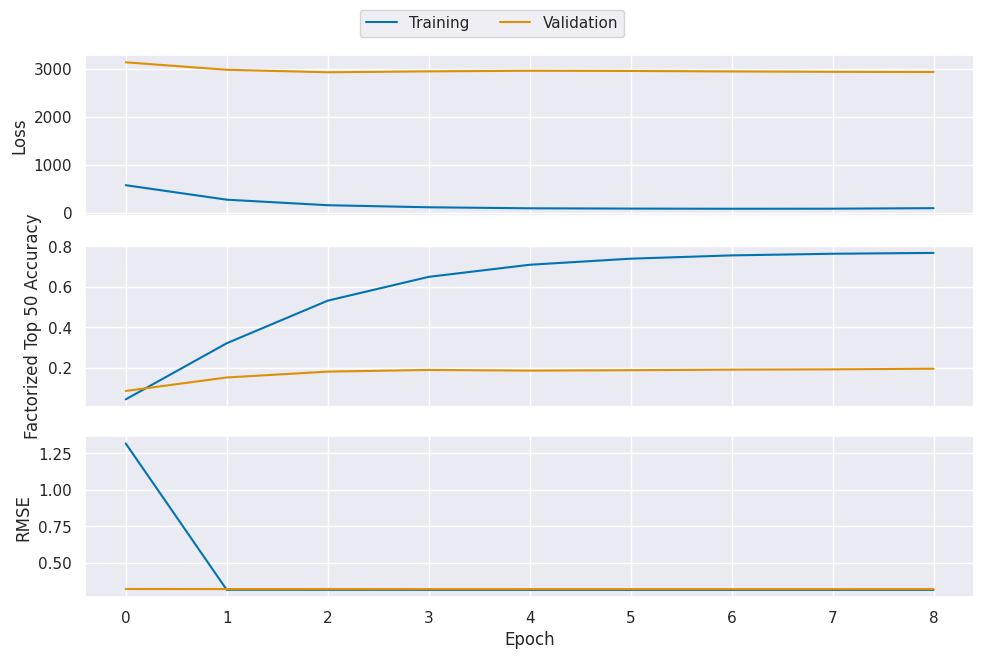

In [34]:
baseline_results = pd.DataFrame(baseline.history.history)

def baseline_analysis(data: pd.DataFrame):
    """
    Function to plot generalization curves.
    """
    fig, ax = plt.subplots(3, 1, figsize=(10, 7), sharex=True)  # Adjusted figsize for better layout
    
    # Plot for total loss and validation loss
    data['total_loss'].plot(ax=ax[0], label='Training')
    data['val_total_loss'].plot(ax=ax[0], label='Validation')    
    ax[0].set_ylabel('Loss')

    # Plot for accuracy
    data[['factorized_top_k/top_50_categorical_accuracy', 'val_factorized_top_k/top_50_categorical_accuracy']].plot(ax=ax[1], legend=False)
    ax[1].set_ylabel('Factorized Top 50 Accuracy')
    
    # Plot for RMSE
    data[['root_mean_squared_error', 'val_root_mean_squared_error']].plot(ax=ax[2], legend=False)
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('RMSE')

    lines, labels = ax[0].get_legend_handles_labels()
    # Place the legend at the lower center
    fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=4)
    
    for a in ax:
        a.set_xticks(range(len(data)))
    # Adjust layout to make space for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.show()

baseline_analysis(baseline_results)

The generalization curve, which plots the training and validation loss against epochs, shows that the loss becomes relatively stable after the second epoch. However, both accuracy and RMSE (Root Mean Square Error) continue to improve until the sixth epoch. This indicates that while the model is beginning to memorize the training data, it is still able to generalize effectively on the validation dataset.

It is important to note that the RMSE does not show any improvement throughout the training process. This suggests that the ranking model is struggling to learn how to accurately predict the product scores based on user feedback, which we defined as our target variable. The underlying issue appears to be the sparsity of user feedback data, which limits the model's ability to learn meaningful patterns.

To address this challenge, implementing resampling techniques may enhance the model's performance by providing a more balanced representation of the data. These techniques can help mitigate the effects of sparse feedback and improve the model's ability to learn from the available data.

### Batch Size Experimentation

Let's try different batch sizes.

In [37]:
bse_path = os.path.join(LOGPATH, "batch_size_exp")

def batch_size_exp() -> None:
    """
    Function to perform batch size experimentation.
    """
    params = copy.deepcopy(PARAMETERS)
    # Try different batch sizes
    batches = [32, 64, 128, 256, 512, 1024]
    results = []
    for i, batch in enumerate(batches):
        params['BATCH_SIZE'] = batch
        params['LOGDIR'] = os.path.join(bse_path, "bs_{}".format(params['BATCH_SIZE']))
        
        logging.info(f"Training model for {params['BATCH_SIZE']} batch size ({i+1}/{len(batches)})")
        init_time = time.time()
        model = train_model(
            train= prep_clicks_train,
            val= prep_clicks_val,
            preprocessing= False,
            params= params,
            logging= True,
            profile= (20, 25), # 5 steps model profiling for optimization analysis
            verbose= 0
        )
        end_time = time.time()

        result = {k: v[-1] for k, v in model.history.history.items() if k.startswith('val')}
        results.append({"batch_size": batch, "logdir": params["LOGDIR"], "training_time": end_time - init_time, **result})

    logging.info(f"Saving results to {os.path.join(bse_path, 'results.csv')}")
    pd.DataFrame(results).to_csv(os.path.join(bse_path, "results.csv"), index=False)
    return

batch_size_exp()

2024-11-09 13:48:42,892 - INFO - Training model for 32 batch size (1/6)
2024-11-09 13:50:35,922 - INFO - Training model for 64 batch size (2/6)
2024-11-09 13:51:59,398 - INFO - Training model for 128 batch size (3/6)
2024-11-09 13:53:11,172 - INFO - Training model for 256 batch size (4/6)
2024-11-09 13:54:22,298 - INFO - Training model for 512 batch size (5/6)
2024-11-09 13:55:26,854 - INFO - Training model for 1024 batch size (6/6)
2024-11-09 13:56:26,173 - INFO - Saving results to logs/batch_size_exp/results.csv


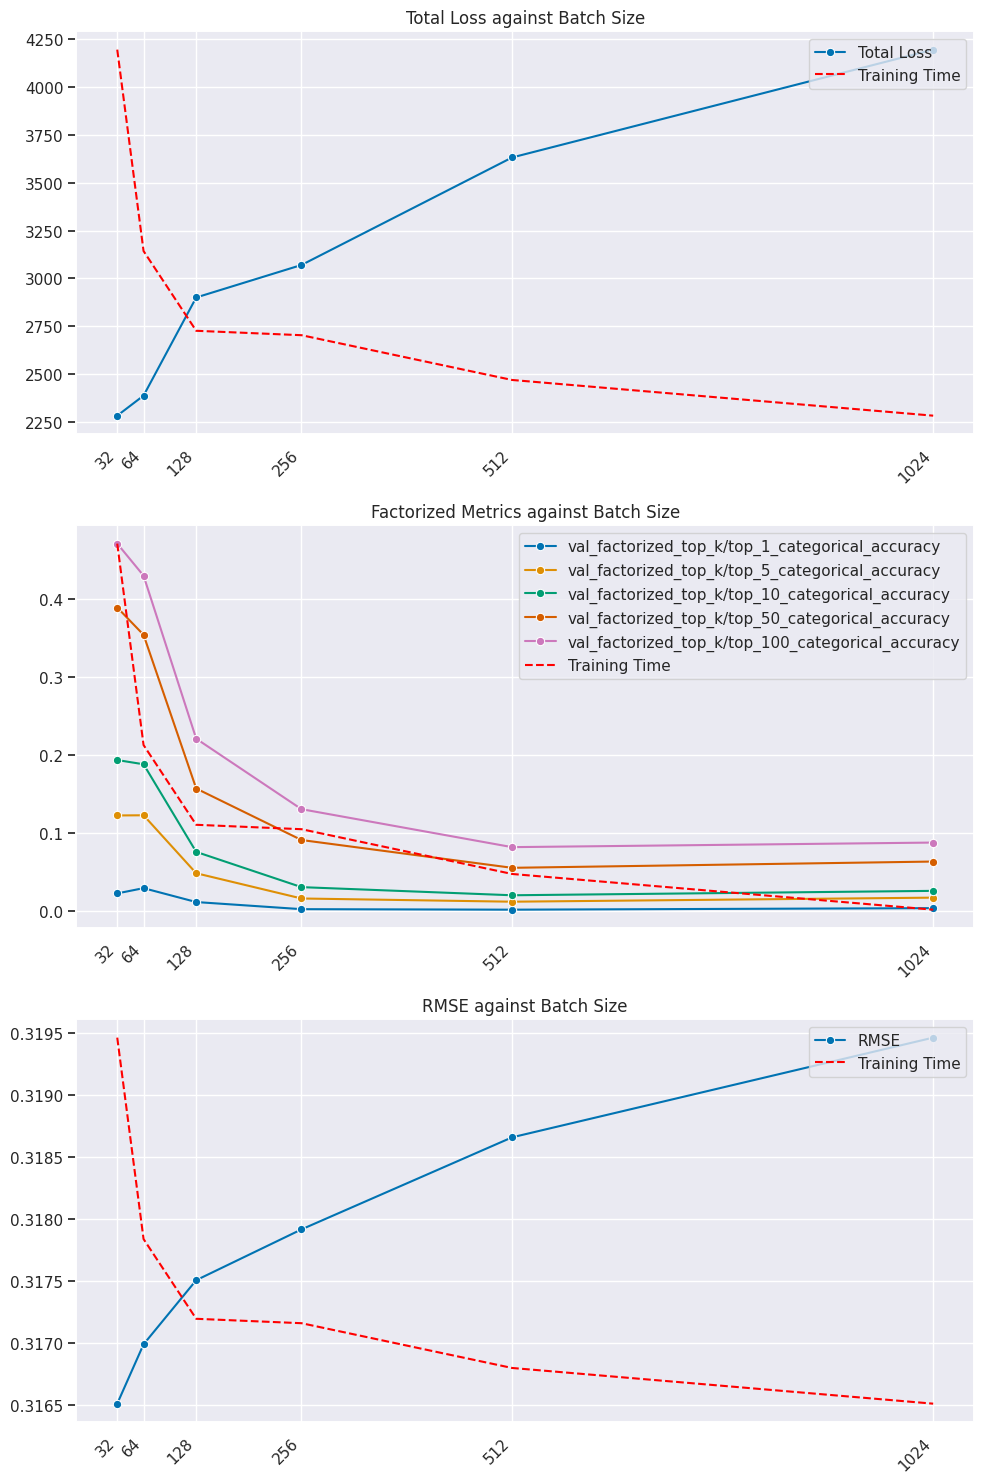

In [38]:
results = pd.read_csv(os.path.join(bse_path, "results.csv"))

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Total Loss against Batch Size Plot
sns.lineplot(data=results, x='batch_size', y='val_total_loss', marker='o', label="Total Loss", ax=axes[0])

# Factorized Top K Metrics against Batch Size Plot
for metric in [c for c in results.columns if c.startswith('val_factorized')]:
    sns.lineplot(data=results, x='batch_size', y=metric, marker='o', label=metric, ax=axes[1])

# RMSE against Batch Size Plot
sns.lineplot(data=results, x='batch_size', y='val_root_mean_squared_error', marker='o', label='RMSE', ax=axes[2])

# Add training time against batch size to each plot, removing label, ticks, and tick labels for twinx
for ax in axes:
    twin_ax = ax.twinx()
    sns.lineplot(data=results, x='batch_size', y='training_time', linestyle='--', color='red', label='Training Time', ax=twin_ax, legend= False)
    
    # Remove the label and ticks for twinx
    twin_ax.set_ylabel('')           # Remove y-axis label for twinx
    twin_ax.set_yticks([])           # Remove y-axis ticks for twinx
    twin_ax.set_yticklabels([])      # Remove y-axis tick labels for twinx
    
    # Combine legends from both ax and twinx
    ax_handles, ax_labels = ax.get_legend_handles_labels()
    twin_handles, twin_labels = twin_ax.get_legend_handles_labels()
    ax.legend(ax_handles + twin_handles, ax_labels + twin_labels, loc='upper right')  # Combine legends

# Set titles
axes[0].set_title('Total Loss against Batch Size')
axes[1].set_title('Factorized Metrics against Batch Size')
axes[2].set_title('RMSE against Batch Size')

# Set labels and ticks
for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks(results['batch_size'])
    ax.set_xticklabels(results['batch_size'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

Batch size selection involves a well-known trade-off between accuracy and performance. Based on the results, a batch size of 64 appears to be the optimal choice in terms of minimizing training time while maintaining high precision.

In [31]:
PARAMETERS['BATCH_SIZE'] = 64

### Feature Selection

To identify the most impactful features while minimizing noise, I will gradually add features to the model, carefully logging the resulting metrics after each addition. I will start with a baseline which follows a standard matrix factorization model. User feature `user_id` and product feature `product_id` are the minimum required variables to develop a matrix factorization model. I will be adding side features looking for improvements.  

Some this parameters were inspired from [Tensorflow Tutorials](https://www.tensorflow.org/recommenders/examples/quickstart) and from experimentation behind the scenes.

The idea is to iteratively add one feature ordered by type and complexity to each model (user and product) and log the resulting metrics.

In [50]:
# Logging path
fs_path = os.path.join(LOGPATH, "feature_selection")

class FeatureSelection():
    def __init__(self, threshold: float = 0.05):
        self.threshold = threshold
        self.params = copy.deepcopy(PARAMETERS)
        # Reset the model features
        self.params['FEATURES']['USER'] = ["time", "score", "cat-user_id"]
        self.params['FEATURES']['PRODUCT'] = ["cat-product_id"]
        
        # Remove the initial user and product features
        self.model_user_features = [e for e in PARAMETERS['FEATURES']['USER'] if e not in self.params['FEATURES']['USER']]
        self.model_product_features = [e for e in PARAMETERS['FEATURES']['PRODUCT'] if e not in self.params['FEATURES']['PRODUCT']]

        # Array to save metrics for each model
        self.results = []

        # Set the order of features
        self.features = list(zip_longest(self.model_user_features, self.model_product_features))
        
        self.retrieval_metric_value = -np.inf
        self.rating_metric_value = np.inf    
    
    def train(self):
        """
        Add feature to the model, train it and return metrics.

        Parameters
        ----------
        parameters: dict
            Dictionary of parameters
        Returns
        -------
        dict
            History of the model
        """
        # Save logging
        model = train_model(
            train= prep_clicks_train,
            val= prep_clicks_val,
            preprocessing= False,
            params= self.params,
            logging= True,
            verbose= 0
        )
        result = {k: v[-1] for k, v in model.history.history.items() if k.startswith('val')}
        result['selected'] = False
        current_retrieval_value = result['val_factorized_top_k/top_50_categorical_accuracy']
        current_rating_value = result['val_root_mean_squared_error']

        # Keep the feature only if it improves one of the metrics and if both metrics don't exceed the threshold
        if (current_retrieval_value >= self.retrieval_metric_value or \
            current_rating_value <= self.rating_metric_value) and \
            (current_retrieval_value > self.retrieval_metric_value - self.threshold and \
            current_rating_value < self.rating_metric_value + self.threshold):
            self.retrieval_metric_value = current_retrieval_value
            self.rating_metric_value = current_rating_value
            result['selected'] = True # set flag to true if the feature will be added to the model
        return result

    def add_feature(self, tower: str, feature: str):
        self.params["FEATURES"][tower.upper()].append(feature)
        self.params["LOGDIR"] = os.path.join(fs_path, f"add_{tower}_{feature}")
        logging.info(f"Added {feature} feature to the {tower.capitalize()} Tower. Fitting...")
        result = self.train()
        if not result['selected']:
            logging.info(f"Feature named {feature} to {tower} tower doesn't improve the model.")
            self.params['FEATURES'][tower.upper()].remove(feature) # Remove feature from the parameters
        return {'tower': tower, 'feature': feature, **result}
    
    def fit(self):
        # Step by step, I will select one feature from user followed by one from product until all features are selected
        # Run the initial baseline model with only two features without adding any feature
        logging.info(f"Training baseline model")
        self.params["LOGDIR"] = os.path.join(fs_path, f"baseline")
        self.results.append({'tower': '', 'feature': 'baseline', **self.train()})

        for user_feature, product_feature in self.features:
            # Add a feature to the user, train the model and save result
            if user_feature:
                self.results.append(self.add_feature('user', user_feature))

            # Add a feature to the product, train the model and save result
            if product_feature:
                self.results.append(self.add_feature('product', product_feature))
        
        # Save results for further analysis
        results_df = pd.DataFrame(self.results)
        results_path = os.path.join(fs_path, "results.csv")
        logging.info(f"Saving results to {results_path}")
        results_df.to_csv(results_path, index_label="run_number")

FeatureSelection().fit()

2024-11-09 15:04:11,868 - INFO - Training baseline model
2024-11-09 15:04:47,151 - INFO - Added cat-channel feature to the User Tower. Fitting...
2024-11-09 15:05:23,978 - INFO - Added cat-category_name feature to the Product Tower. Fitting...
2024-11-09 15:06:03,279 - INFO - Added cat-device_type feature to the User Tower. Fitting...
2024-11-09 15:06:42,933 - INFO - Added cat-merchant_name feature to the Product Tower. Fitting...
2024-11-09 15:07:23,592 - INFO - Added int-hour feature to the User Tower. Fitting...
2024-11-09 15:08:05,188 - INFO - Added cat-merchant_city feature to the Product Tower. Fitting...
2024-11-09 15:08:49,016 - INFO - Feature named cat-merchant_city to product tower doesn't improve the model.
2024-11-09 15:08:49,018 - INFO - Added int-day_of_week feature to the User Tower. Fitting...
2024-11-09 15:09:31,858 - INFO - Added cat-merchant_state feature to the Product Tower. Fitting...
2024-11-09 15:10:20,351 - INFO - Added text-query_text feature to the User Tower

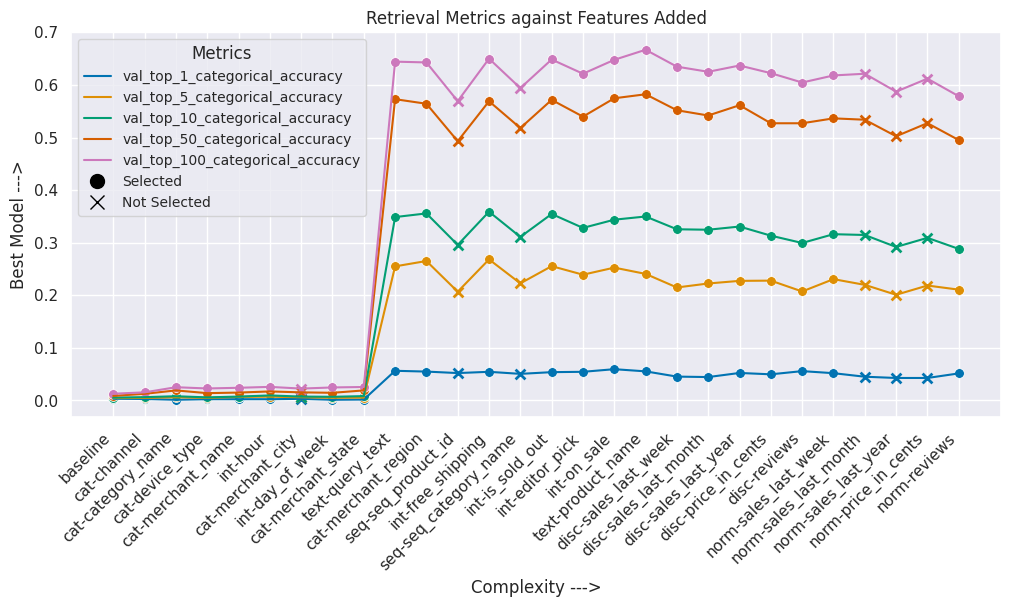

In [42]:
# Read results from Feature Selection
results = pd.read_csv(os.path.join(fs_path, "results.csv"))

def fs_plot(values: list):
    # Plot Retrieval Metrics against Features Added
    fig = plt.figure(figsize=(12, 5))

    for value in values:
        line_plot = sns.lineplot(data=results, x='feature', y=value, label= value, markers=True)
        line_color = line_plot.get_lines()[-1].get_color()
        sns.scatterplot(data=results[results['selected']], x='feature', y=value, marker='o', color=line_color, s=50)
        sns.scatterplot(data=results[~results['selected']], x='feature', y=value, marker='x', color=line_color, s=50, linewidth=2)

    legend_elements = [
            Line2D([0], [0], color='black', marker='o', markersize=10, 
                              label='Selected', linestyle='None', linewidth=2),
        Line2D([0], [0], color='black', marker='x', markersize=10, 
                              label='Not Selected', linestyle='None', linewidth=2)
    ]

    # Add the default legend for lines, and then the manual marker legend
    plt.legend(
        title='Metrics', 
        handles=plt.gca().get_legend().legend_handles + legend_elements,
        fontsize= 10
    )
    plt.xticks(rotation=45, ha= 'right')
    plt.xlabel('Complexity --->')
    return fig

results.columns = [col.replace('val_factorized_top_k/', 'val_') for col in results.columns]
plot = fs_plot(values = [c for c in results.columns if c.startswith('val_top')])
plt.title('Retrieval Metrics against Features Added')
plt.ylabel('Best Model --->')
plt.show()

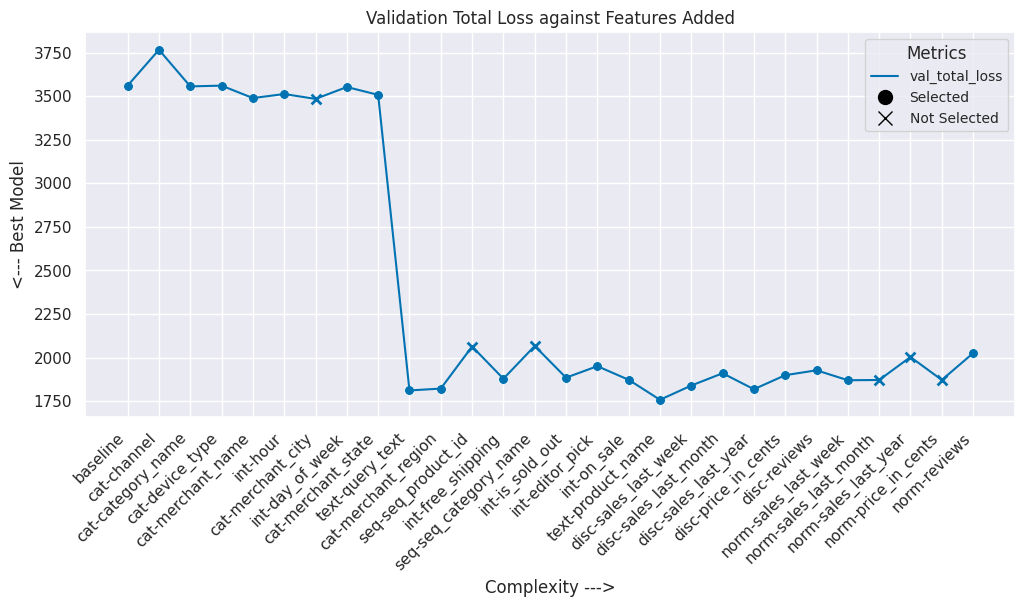

In [52]:
plot = fs_plot(values = ['val_total_loss'])

plt.title('Validation Total Loss against Features Added')
plt.ylabel('<--- Best Model')
plt.show()

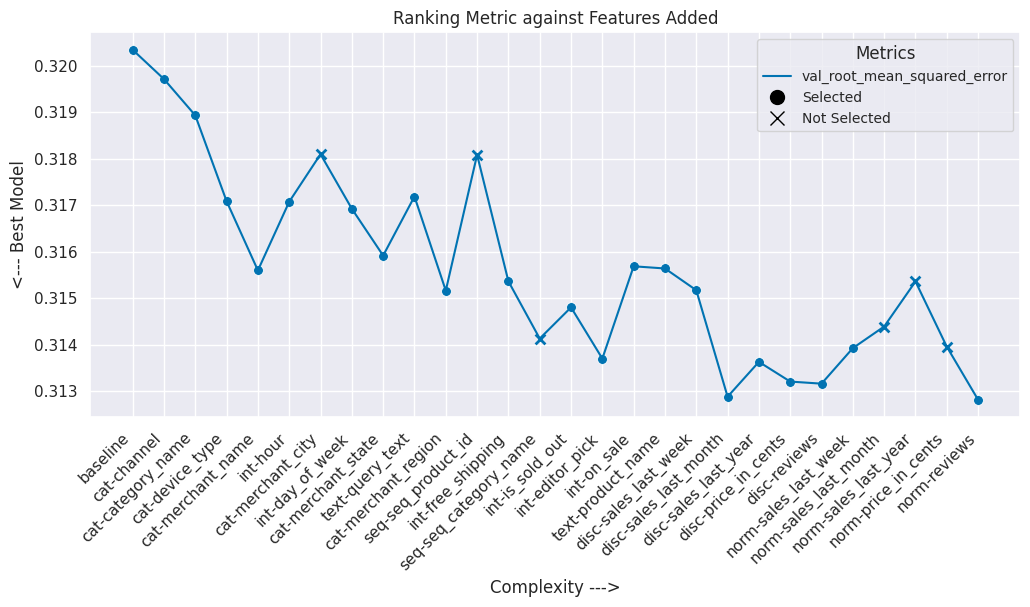

In [53]:
plot = fs_plot(values = ['val_root_mean_squared_error'])

plt.title('Ranking Metric against Features Added')
plt.ylabel('<--- Best Model')
plt.show()

Based on the results plotted above, the following features demonstrate a decrease in accuracy when included in the model:

In [32]:
dropped_features = [
    'cat-merchant_city',
    'seq-seq_product_id',
    'seq-seq_category_name',
    'norm-sales_last_month',
    'norm-sales_last_year',
    'norm-price_in_cents'
]

Sequential features, `seq_product_id` and `seq_category_name`, show limited utility, as only 20% of users have recorded multiple clicks. Thus, including this sequential data as a feature does not provide significant value. By excluding sequential features, I am now able to work with shuffled versions of the training and validation datasets, which may further simplify the model.

### Features

In [33]:
PARAMETERS['FEATURES']['USER'] = [f for f in PARAMETERS['FEATURES']['USER'] if f not in dropped_features]
PARAMETERS['FEATURES']['PRODUCT'] = [f for f in PARAMETERS['FEATURES']['PRODUCT'] if f not in dropped_features]
pprint.pprint(PARAMETERS['FEATURES'])

{'PRODUCT': ['cat-product_id',
             'cat-category_name',
             'cat-merchant_name',
             'cat-merchant_state',
             'cat-merchant_region',
             'int-free_shipping',
             'int-is_sold_out',
             'int-editor_pick',
             'int-on_sale',
             'text-product_name',
             'disc-sales_last_week',
             'disc-sales_last_month',
             'disc-sales_last_year',
             'disc-price_in_cents',
             'disc-reviews',
             'norm-sales_last_week',
             'norm-reviews'],
 'USER': ['time',
          'cat-user_id',
          'cat-channel',
          'cat-device_type',
          'int-hour',
          'int-day_of_week',
          'text-query_text',
          'score']}


### Deep Retrieval Experiment
Test if it is worth to use deep layers in my retrieval model given the available data.

In [37]:
dl_path = os.path.join(LOGPATH, 'deep_layers_exp')

def deep_layers_exp():
    params = copy.deepcopy(PARAMETERS)
    # Try different architectures from 0 to 2 deep layers
    deep_layers = [[32], [64, 32], [128, 63, 32]]

    results = []
    for layers in deep_layers:
        # Use the number of layers as ID of each model
        n_layers = len(layers) - 1
        logging.info(f"Training model with the following layers: \n- User Layers: {layers} \n- Product Layers: {layers}\n")
        params['LOGDIR'] = os.path.join(dl_path, f'{n_layers}_deep_layers')
        # Update layers architecture for each tower
        params['MODEL']['user_layers'] = layers
        params['MODEL']['product_layers'] = layers
        
        result = train_CV(params)
        result['n_layers'] = n_layers
        results.append(result)

    results_df = pd.concat(results, ignore_index= True)
    results_path = os.path.join(dl_path, 'cv_results.csv')
    logging.info(f"Saving results to {results_path}")
    results_df.to_csv(results_path, index=False)

deep_layers_exp()

2024-11-30 15:51:45,570 - INFO - Training model with the following layers: 
- User Layers: [32] 
- Product Layers: [32]



Cross Validation: 100%|██████████| 5/5 [05:30<00:00, 66.11s/fold]

2024-11-30 15:57:16,122 - INFO - Training model with the following layers: 
- User Layers: [64, 32] 
- Product Layers: [64, 32]




Cross Validation: 100%|██████████| 5/5 [05:31<00:00, 66.21s/fold]

2024-11-30 16:02:47,162 - INFO - Training model with the following layers: 
- User Layers: [128, 63, 32] 
- Product Layers: [128, 63, 32]




Cross Validation: 100%|██████████| 5/5 [05:43<00:00, 68.68s/fold]

2024-11-30 16:08:30,591 - INFO - Saving results to logs/deep_layers_exp/cv_results.csv


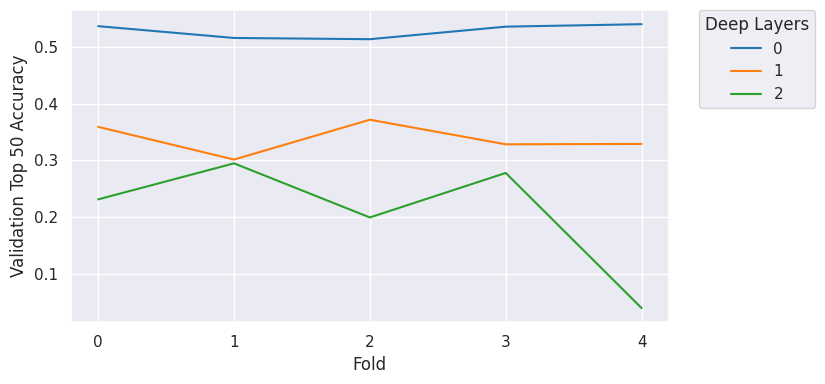

In [38]:
results_df = pd.read_csv(os.path.join(dl_path, 'cv_results.csv'))

fig = plt.figure(figsize=(10, 4))

palette = ["#1f77b4", "#ff7f0e", "#2ca02c"]
# Plot the retrieval metric against folds
sns.lineplot(
    x='fold', 
    y='val_factorized_top_k/top_50_categorical_accuracy', 
    hue='n_layers', 
    data=results_df, 
    palette= palette
)
plt.xlabel("Fold")
plt.ylabel("Validation Top 50 Accuracy")
plt.xticks(range(0, 5))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Deep Layers')
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for the legend
plt.show()

We are focusing solely on analyzing the retrieval metrics, as the deep layers in this context impact only the retrieval model.

### Resampling
After experimenting with the model, I observed that the **RMSE** metric along the *rating model* showed no improvement. Given the sparsity of my dataset, I plan to address this issue by applying resampling techniques to balance the data, specifically focusing on the `score` feature, which serves as the target variable.

The `score` feature exhibits significant skewness, which could be contributing to the model's poor performance. To mitigate this, I will utilize the *ImbalancedLearningRegression* package, implementing various resampling strategies. The goal is to redistribute the data more evenly across the range of `score` values, thus reducing the imbalance and potentially enhancing the model’s predictive accuracy.

By balancing the dataset through resampling, I aim to improve the RMSE metric and overall performance of the ranking task.

Reference:  
*Wu, W., Kunz, N., & Branco, P. (2022, September). ImbalancedLearningRegression-A Python Package to Tackle the Imbalanced Regression Problem. In Joint European Conference on Machine Learning and Knowledge Discovery in Databases (pp. 645-648). Cham: Springer Nature Switzerland.*

In [40]:
def resample(data: pd.DataFrame):
    # The rel_ctrl_pts_rg argument takes a 2d array (matrix). 
    # It is used to manually specify the regions of interest or rare "minority" values in y. 
    # The first column indicates the y values of interest, the second column indicates a mapped value of relevance, either 0 or 1, 
    # where 0 is the least relevant and 1 is the most relevant, and the third column is indicative. 
    # It will be adjusted afterwards, use 0 in most cases.
    rg_matrix = [
        [0.5, 1, 0], # minority class, high relevance
        [1.0, 1, 0], # minority class, high relevance
        [0, 0, 0] # majority class, low relevance
    ]

    # Random Oversample
    logging.info("Random Oversample")
    ro_clicks_train_df = iblr.ro(
        data = data,
        y = 'score',
        rel_method="manual", # Set manual to use manual relevance control
        rel_ctrl_pts_rg= rg_matrix # Set relevance control points
    )

    # Random Undersampling
    logging.info("Random Undersampling")
    ru_clicks_train_df = iblr.random_under(
        data = data,
        y = 'score',
        rel_method="manual",
        rel_ctrl_pts_rg= rg_matrix
    )

    # Gaussian Noise
    logging.info("Gaussian Noise")
    gn_clicks_train_df = iblr.gn(
        data = data,
        y = 'score',
        rel_method="manual",
        rel_ctrl_pts_rg= rg_matrix
    )

    # Print shapes
    print(f"Original shape: {data.shape}")
    print(f"RO shape: {ro_clicks_train_df.shape}")
    print(f"RU shape: {ru_clicks_train_df.shape}")
    print(f"Gaussian Noise shape: {gn_clicks_train_df.shape}")

    # Load as dataset
    logging.info("Load as dataset")
    features = [f for f in user_features + product_features if not f.startswith("seq")]
    orig_clicks_train = create_dataset(data, features)
    ro_clicks_train = create_dataset(ro_clicks_train_df, features)
    ru_clicks_train = create_dataset(ru_clicks_train_df, features)
    gn_clicks_train = create_dataset(gn_clicks_train_df, features)

    # Plot densities
    ro_clicks_train_df['score'].plot(kind="kde", label="Random Oversampling", title="Resampling Comparison")
    ru_clicks_train_df['score'].plot(kind="kde", label="Random Undersampling")
    gn_clicks_train_df['score'].plot(kind="kde", label="Gaussian Noise")
    data['score'].plot(kind="kde", label="Original")
    plt.xlabel("Score")
    plt.xticks([0, 0.5, 1])
    plt.legend()
    plt.show()

    return orig_clicks_train, ro_clicks_train, ru_clicks_train, gn_clicks_train

2024-11-24 19:49:54,961 - INFO - Resample training
2024-11-24 19:49:54,973 - INFO - Random Oversample


r_index: 100%|##########| 5480/5480 [00:02<00:00, 1894.99it/s]


2024-11-24 19:50:07,364 - INFO - Random Undersampling


new_index: 100%|##########| 8568/8568 [00:03<00:00, 2251.02it/s]


2024-11-24 19:50:53,270 - INFO - Gaussian Noise


r_index: 100%|##########| 2392/2392 [00:33<00:00, 71.71it/s]


Original shape: (17136, 28)
RO shape: (22616, 28)
RU shape: (11656, 28)
Gaussian Noise shape: (17136, 28)
2024-11-24 19:52:19,154 - INFO - Load as dataset


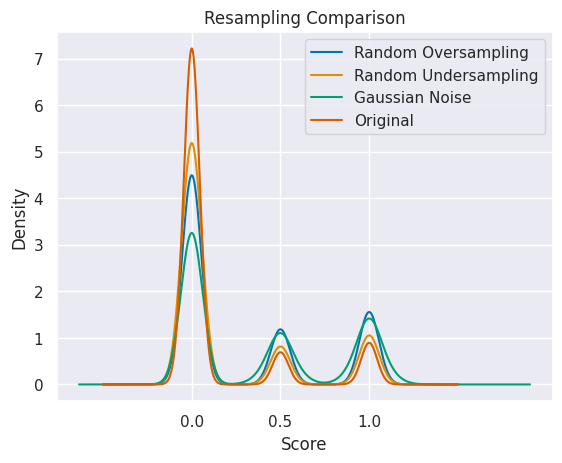

2024-11-24 19:52:20,634 - INFO - Training model for original dataset (1/4)
2024-11-24 19:53:28,950 - INFO - Training model for RO dataset (2/4)
2024-11-24 19:54:50,414 - INFO - Training model for RU dataset (3/4)
2024-11-24 19:55:59,173 - INFO - Training model for GN dataset (4/4)
2024-11-24 19:57:06,461 - INFO - Saving results to logs/resample/results.csv


In [41]:
resample_path = os.path.join(LOGPATH, "resample")

def resample_training():
    params = copy.deepcopy(PARAMETERS)
    
    logging.info("Resample training")

    # Sequential features aren't accepted by the resampling methods.
    original_clicks_train = clicks_train_df_sh.drop(['seq_product_id', 'seq_category_name'], axis=1).reset_index(drop=True)  # Has to be a pandas dataframe

    orig_clicks_train, ro_clicks_train, ru_clicks_train, gn_clicks_train = resample(original_clicks_train)
    # list of tf datasets
    train_sets = [orig_clicks_train, ro_clicks_train, ru_clicks_train, gn_clicks_train]
    train_names = ["original", "RO", "RU", "GN"]

    results = []
    for i, (train, name) in enumerate(zip(train_sets, train_names)):
        params['LOGDIR'] = os.path.join(resample_path, name)
        logging.info(f"Training model for {name} dataset ({i+1}/{len(train_sets)})")
        model = train_model(
            train = train,
            val = clicks_val_sh,
            preprocessing= True,
            params= params,
            logging=True,
            verbose= 0
        )
        result = {k: v[-1] for k, v in model.history.history.items() if k.startswith('val')}
        results.append({'name': name, **result})

    results_path = os.path.join(resample_path, "results.csv")
    logging.info("Saving results to " + results_path)
    pd.DataFrame(results).to_csv(results_path, index=False)

# Uncomment to run
resample_training()

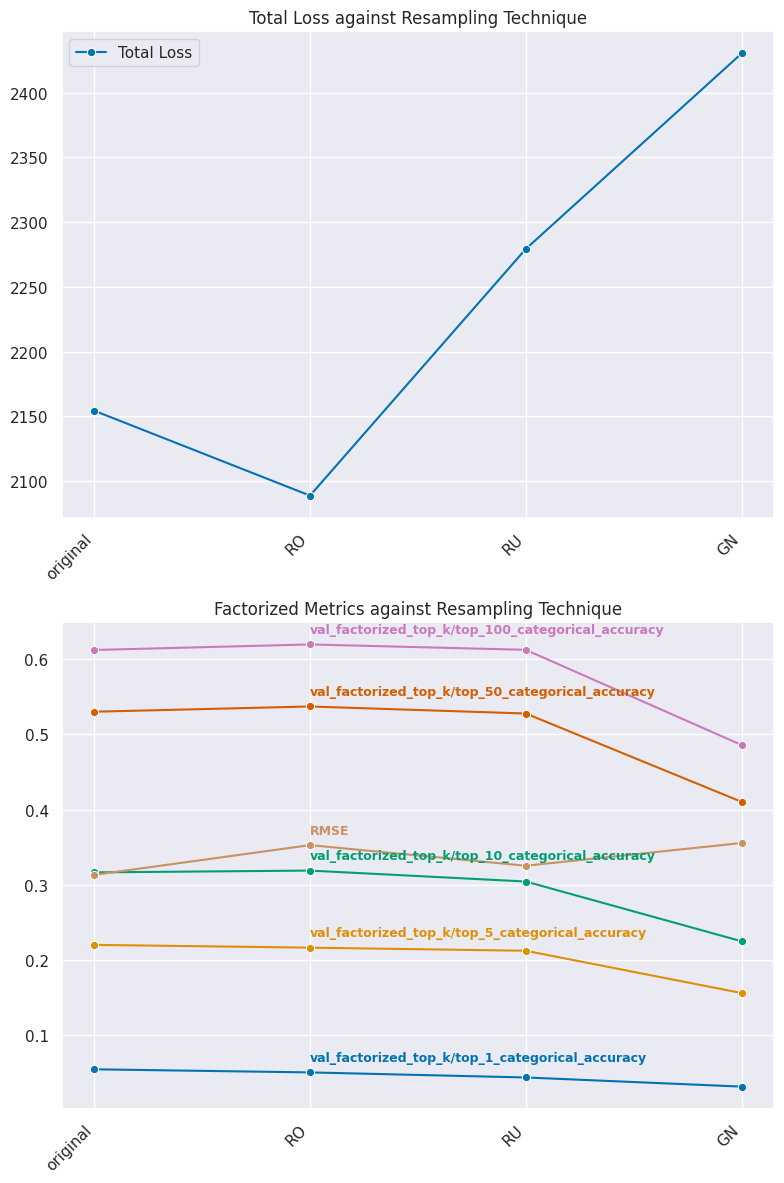

In [42]:
results = pd.read_csv(os.path.join(resample_path, "results.csv"))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

# Total Loss against Batch Size Plot
sns.lineplot(data=results, x='name', y='val_total_loss', marker='o', label="Total Loss", ax=axes[0])

# Factorized Top K Metrics against Batch Size Plot
retrieval_metrics = [c for c in results.columns if c.startswith('val_factorized')]
for metric in retrieval_metrics:
    sns.lineplot(data=results, x='name', y=metric, marker='o', label=metric, ax=axes[1])

# RMSE against Batch Size Plot
sns.lineplot(data=results, x='name', y='val_root_mean_squared_error', marker='o', label='RMSE', ax=axes[1])

# Set titles
axes[0].set_title('Total Loss against Resampling Technique')
axes[1].set_title('Factorized Metrics against Resampling Technique')

# Set labels and ticks
for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks(results['name'])
    ax.set_xticklabels(results['name'], rotation=45, ha='right')

# Place labels directly over the lines
for line, label in zip(plt.gca().get_lines(), retrieval_metrics + ['RMSE']):
    x = line.get_xdata()[1]
    y = line.get_ydata()[1] + 0.02
    
    plt.text(x, y, label, color=line.get_color(), fontweight='bold', va='center', fontsize= 9)    

plt.legend().set_visible(False)
plt.tight_layout()
plt.show()

**Conclusion**: The resampling techniques applied did not result in a significant improvement over the original dataset. The ranking model's performance remained largely unchanged, suggesting that the model may be limited by the inherent sparsity and lack of sufficient data. This could indicate that the model has already extracted most of the learnable patterns from the data, and further improvements may require either more comprehensive data or a different modeling approach.

## Hyperparameter Tuning

### Objective Function

In [38]:
# Objective function to be maximized.
def objective(trial):
    """
    Optuna Objective Function to be optimized.
    """    
    def deep_layers(trial, units: list) -> list:
        """
        Helper function to suggest deep layers arquitectures.

        Parameters
        ----------
        trial : optuna.trial
            Optuna trial
        units : list
            List of units
        Returns
        -------
        list
            Deep layers arquitectures
        """
        # I will ensure in rating model at least one deep layer
        deep_layers = trial.suggest_int("rating_layers", 1, 2)

        layers = []
        for l in range(deep_layers):            
            layers.append(trial.suggest_categorical(f'rating_units_l{l}', units))
        # Add 1 unit in output layer by regression
        layers.append(1)
        return layers
    

    # Clear clutter from previous TensorFlow graphs.
    tf.keras.backend.clear_session()
    
    # Define parameters and suggest values to be tuned and optimized
    params = copy.deepcopy(PARAMETERS)
    params['LOGDIR'] = os.path.join(LOGPATH, "optuna", "run_{:02d}".format(trial.number))
    params['LEARNING_RATE']['initial_learning_rate'] = trial.suggest_categorical('initial_learning_rate', [0.1, 0.01])
    params['MODEL']['emb_weight'] = trial.suggest_int('emb_weight', 4, 16, step=4)
    output_layer = trial.suggest_categorical('output_layer', [8, 16, 32, 64])
    params['MODEL']['user_layers'] = [output_layer]
    params['MODEL']['product_layers'] = [output_layer]
    params['MODEL']['rating_layers'] = deep_layers(trial, [8, 16, 32, 64, 128, 256])
    params['MODEL']['dropout'] = trial.suggest_float('dropout', 0.0, 0.5, step=0.1)
    params['MODEL']['cross_layer'] = trial.suggest_categorical('cross_layer', [True, False])
    params['MODEL']['optimizer'] = trial.suggest_categorical('optimizer', ['Adagrad', 'Adam'])

    model = train_model(
        train= prep_clicks_train_sh,
        val = prep_clicks_val_sh,
        preprocessing= False, 
        params= params,
        logging= True,
        verbose= 0
    )
    
    # Get metrics
    trial_results = {m: v[-1] for m, v in model.history.history.items() if m.startswith('val')}
      
    # Save metrics as attributes for further analysis
    for m, v in trial_results.items():
        trial.set_user_attr(m, v)
    
    # Return the objective values
    return (
        trial_results['val_factorized_top_k/top_50_categorical_accuracy'],
        trial_results['val_root_mean_squared_error']
    )


storage = optuna.storages.JournalStorage(
    optuna.storages.JournalFileStorage("/kaggle/working/hp.log"),  # NFS path for distributed optimization
)

# Create a study
study = optuna.create_study(
    storage=storage,
    study_name="recommendation_engine",
    directions=['maximize', 'minimize'],
    load_if_exists=True
)

# Perform optimization
study.optimize(objective, n_trials=5) 

[I 2024-11-30 15:23:57,590] Using an existing study with name 'recommendation_engine' instead of creating a new one.
I0000 00:00:1732980244.607713     214 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
[I 2024-11-30 15:25:09,876] Trial 512 finished with values: [0.1521267294883728, 0.313846617937088] and parameters: {'initial_learning_rate': 0.1, 'emb_weight': 12, 'output_layer': 16, 'rating_layers': 2, 'rating_units_l0': 8, 'rating_units_l1': 64, 'dropout': 0.5, 'cross_layer': False, 'optimizer': 'Adagrad'}.
[I 2024-11-30 15:26:12,528] Trial 513 finished with values: [0.2552083432674408, 0.3145160973072052] and parameters: {'initial_learning_rate': 0.01, 'emb_weight': 12, 'output_layer': 16, 'rating_layers': 1, 'rating_units_l0': 128, 'dropout': 0.2, 'cross_layer': False, 'optimizer': 'Adagrad'}.
[I 2024-11-30 15:27:45,176] Trial 514 finished with values: [0.5145399570465088, 0.31494060158729553] and parameters: {'

For demonstration purposes I runned the optimzation for 5 trials only to capture the output.
The whole optimization (~500 trials) is better to be made in multiprocessing with a `.py` file containing the objective function above. I followed this process behind the scenes.

### Results Processing and Analysis

In [39]:
# Define parameters and metrics columns
hp_params = [
    'dropout', 'emb_weight', 'output_layer', 
    'initial_learning_rate', 'cross_layer', 'optimizer',
    'rating_layers', 'rating_units_l0', 'rating_units_l1'
]
hp_metrics = [
    'val_factorized_top_k/top_100_categorical_accuracy',
    'val_factorized_top_k/top_50_categorical_accuracy',
    'val_factorized_top_k/top_10_categorical_accuracy',
    'val_factorized_top_k/top_5_categorical_accuracy', 
    'val_factorized_top_k/top_1_categorical_accuracy',
    'val_root_mean_squared_error', 'val_loss'
]

# Helper function to parse study to pd.DataFrame and apply transformations
def process_study(study) -> pd.DataFrame:
    study_df = study.trials_dataframe()
    study_df.columns = study_df.columns.str.replace('user_attrs_', '')
    study_df.columns = study_df.columns.str.replace('params_', '')
    study_df = study_df[['number'] + hp_params + hp_metrics + ['state']]
    study_df['dropout'] = study_df['dropout'].round(1)
    study_df.fillna(0, inplace=True) # Replace non units in layers with 0
    units_cols = study_df.columns[study_df.columns.str.contains('unit')]
    study_df[units_cols] = study_df[units_cols].astype(int) # Convert units to int
    return study_df

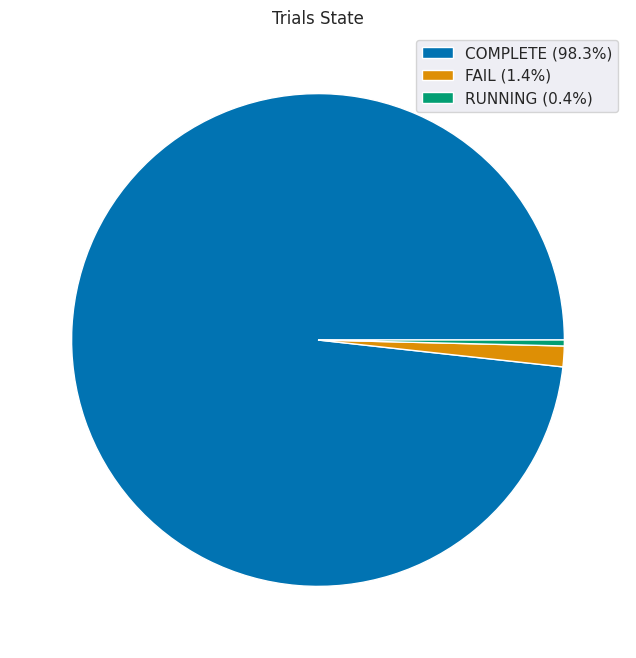

In [40]:
# Convert study to dataframe and apply transformations
study_df = process_study(study)

fig = plt.figure(figsize=(8, 8))

# Calculate value counts and corresponding percentages
value_counts = study_df['state'].value_counts()
percentages = value_counts / value_counts.sum() * 100

# Create labels with both the state names and percentages
labels = [f'{state} ({percentage:.1f}%)' for state, percentage in zip(value_counts.index, percentages)]

# Plot the pie chart without the `autopct` parameter
value_counts.plot(kind='pie', labels=['' for i in range(len(labels))], ylabel='', title='Trials State')
plt.legend(labels=labels, loc='upper right')
plt.show()

In [41]:
# Remove not completed trials
study_df = study_df[study_df['state'] == 'COMPLETE'].copy()

### Pareto Front

In [42]:
# Create hover template
parameter_template = "".join([f"{p}: %{{text[{i + 1}]}}<br>" for i, p in enumerate(hp_params)])
metric_template = "".join([f"{m}: %{{text[{i + len(hp_params) + 1}]:.3f}}<br>" for i, m in enumerate(hp_metrics)])
hover_template = (
    "Trial number: %{text[0]}<br>" +
    "<br><b>Parameters</b><br>" +
    parameter_template +
    "<br><b>Metrics</b><br>" +
    metric_template +
    "<extra></extra>"
)

# Generate the color map for each parameter
colors = px.colors.qualitative.Set1

for param in hp_params:
    color_map = {cls: colors[i] for i, cls in enumerate(study_df[param].unique())}
    study_df[f"color_{param}"] = study_df[param].map(color_map)

# Create the initial figure
fig = go.Figure()

# Add default trace
fig.add_trace(go.Scatter(
    x=study_df['val_factorized_top_k/top_50_categorical_accuracy'],
    y=study_df['val_root_mean_squared_error'],
    mode='markers',
    marker=dict(size=8, color='gray'),
    name="None",
    text=study_df[['number'] + hp_params + hp_metrics],
    hovertemplate=hover_template
))

# Add traces for each parameter
for param in hp_params:
    for value in sorted(study_df[param].unique()):
        df = study_df[study_df[param] == value]
        fig.add_trace(go.Scatter(
            x=df['val_factorized_top_k/top_50_categorical_accuracy'],
            y=df['val_root_mean_squared_error'],
            mode='markers',
            marker=dict(size=8, color=df[f"color_{param}"]),
            name=f"{param}: {value}",
            text=df[['number'] + hp_params + hp_metrics],
            hovertemplate=hover_template
        ))

params_traces = [data.name for data in fig.data]
# Create a dropdown menu to change the color of the markers
updatemenus = [
    {
        'buttons':[
            {
                'label': param,
                'method': 'restyle',
                'args': [{'visible': [param in trace for trace in params_traces]}]
            }
            for param in ["None"] + hp_params
        ],
        'direction': 'down',
        'showactive': True,
        'x': 0.25,  # Positioning
        'xanchor': 'left',
        'y': 1.18,
        'yanchor': 'top',
        'name': 'Group'
    }
]

# Update layout with dropdown and axis titles
fig.update_layout(
    updatemenus=updatemenus,
    title="Pareto Front | Parameter: ",
    xaxis_title="Retrieval - Factorized Top 50 Categorical Accuracy",
    yaxis_title="Ranking - Root Mean Squared Error",
    yaxis=dict(rangemode='tozero', range=[0.31, 0.32]), 
    height=600,
    width=1200,
)

# Show the first figure as default
for k in range(1, len(fig.data)):
    fig.update_traces(visible=False, selector=k)
fig.show()

### Hyperparameter Importance

In [43]:
# Parameters Importance by 'val_factorized_top_k/top_100_categorical_accuracy'
fig1= optuna.visualization.plot_param_importances(
    study, target=lambda t: t.values[0], target_name="val_factorized_top_k/top_50_categorical_accuracy"
)

# Parameters Importance by 'val_root_mean_squared_error'
fig2= optuna.visualization.plot_param_importances(
    study, target=lambda t: t.values[1], target_name="val_root_mean_squared_error"
)

# Create a subplot layout with 1 row and 2 columns
combined_fig = make_subplots(rows=2, cols=1, 
                             subplot_titles=(
                                 "By <b>val_factorized_top_k/top_50_categorical_accuracy</b>",
                                 "By <b>val_root_mean_squared_error</b>"
                             ))

combined_fig.add_trace(fig1.data[0], row=1, col=1)
combined_fig.add_trace(fig2.data[0], row=2, col=1)

combined_fig.update_layout(
    title="Hyperparameter Importance",
    height=800,  
    width=1000,  
    showlegend=False
)
combined_fig.show()

### Parallel Coordinate Plot

In [44]:
# Select only numerical parameters
num_cols = study_df[hp_params].select_dtypes(include='number').columns

# Build Parallel Coordinate Plot
layout = go.Layout(title="Parallel Coordinate Plot")
traces= [
    go.Parcoords(
        dimensions=
            [dict(label = col, values = study_df[col]) for col in num_cols] +
            [
                dict(tickvals = [0, 1], ticktext = ["Adagrad", "Adam"], label = "optimizer", values = study_df["optimizer"].replace({"Adagrad": 0, "Adam": 1})),
                dict(tickvals = [0, 1], ticktext = ["No", "Yes"], label = "cross_layer", values = study_df["cross_layer"].replace({False: 0, True: 1})),
                dict(range=(0, 1), label = "val_fact_top50", values = study_df["val_factorized_top_k/top_50_categorical_accuracy"]),
                dict(range=(0, 1), label = "val_rmse", values = study_df["val_root_mean_squared_error"])
            ],
        labelangle=30,
        labelside="bottom",
    )
]

fig = go.Figure(data=traces, layout=layout)
fig.show()

### Best Hyperparameters

Because the objective function is multi-objective, the best parameters are present in the best trials.

In [45]:
best_trials = study_df[study_df['number'].isin([d.number for d in study.best_trials])]

fig = go.Figure()
# Add scatter plot trace
fig.add_trace(go.Scatter(
    x=best_trials['val_factorized_top_k/top_50_categorical_accuracy'],
    y=best_trials['val_root_mean_squared_error'],
    mode='markers',
    name='Best Trials',
    marker=dict(size=7, color='red'),
    text=best_trials[['number'] + hp_params + hp_metrics],
    hovertemplate=hover_template
))
# Update layout for better visualization
fig.update_layout(
    title="Pareto Front - Best Trials",
    xaxis_title="Retrieval - Factorized Top 50 Categorical Accuracy",
    yaxis_title="Ranking - Root Mean Squared Error",
    yaxis=dict(rangemode='tozero', range=[0.31, 0.32]) # Set rmse range to improve the visualization
)
fig.show()

Some of the best models by retrieval are really expensive and complex, like cross layer enabled, huge number of units in rating deep layers and the smallest learning rate. So I will chose one is less complex and lightweight, while keeping best possible values for retrieval and ranking metrics values.

Trial selected: **471**  
Best Hyperparameters:  
| Parameter | Value |
| --- | --- |
| cross_layer | False |
| dropout | 0.1 |
| emb_weight | 8 |
| initial_learning_rate | 0.1 |
| optimizer | Adagrad |
| output_layer | 32 |
| rating_layers | 2 |
| rating_units_l0 | 32|
| rating_units_l1 | 64|

In [39]:
PARAMETERS['LEARNING_RATE']['initial_learning_rate'] = 0.1
PARAMETERS['MODEL'] = {
    'emb_weight': 8,
    'user_layers': [32],
    'product_layers': [32],
    'rating_layers': [32, 64, 1],
    'dropout': 0.1,
    'optimizer': 'Adagrad',
    'cross_layer': False,
}

Despite the fact the model performs better without deep layers in query and candidates towers, also called deep retrieval model, as the dataset and the number of side features increase, incorporating deep layers will become essential for achieving better results.

## Final Model

<img src="data/model.png" alt="Model Architecture Overview" width="739" height="1455">

**NOTE**: Shape dimensions are (batch_size, tensor_size).

In [40]:
# Model final parameters
pprint.pprint(PARAMETERS)

{'BATCH_SIZE': 64,
 'EARLY_STOPPING': {'delta_rating': 0.01,
                    'delta_retrieval': 0.01,
                    'patience': 3,
                    'rating_metric': 'val_root_mean_squared_error',
                    'retrieval_metric': 'val_factorized_top_k/top_50_categorical_accuracy',
                    'start_from_epoch': 5},
 'FEATURES': {'PRODUCT': ['cat-product_id',
                          'cat-category_name',
                          'cat-merchant_name',
                          'cat-merchant_state',
                          'cat-merchant_region',
                          'int-free_shipping',
                          'int-is_sold_out',
                          'int-editor_pick',
                          'int-on_sale',
                          'text-product_name',
                          'disc-sales_last_week',
                          'disc-sales_last_month',
                          'disc-sales_last_year',
                          'disc-price_in_cen

### Cross Validation Evaluation
Given the final parameters, I will evaluate my model using cross-validation.

In [43]:
params = copy.deepcopy(PARAMETERS)
params['LOGDIR'] = os.path.join(LOGPATH, 'selected_model')

results_df = train_CV(params)

Cross Validation: 100%|██████████| 5/5 [05:27<00:00, 65.41s/fold]


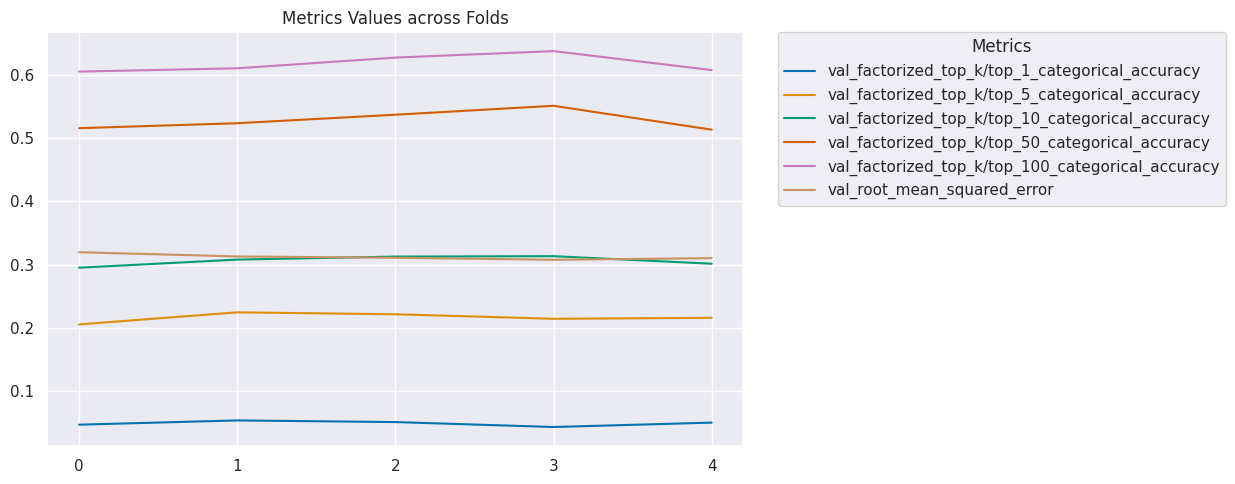

In [44]:
cv_data = results_df.drop(['n_epochs', 'val_loss', 'val_regularization_loss', 'val_total_loss', 'fold'], axis=1)
fig = plt.figure(figsize=(15, 5))

for col in cv_data.columns:
    plt.plot(cv_data[col], label=col)

plt.xticks(range(0, 5))
plt.title('Metrics Values across Folds')
# Move the legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Metrics')

# Use tight layout to automatically adjust subplot params
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for the legend
plt.show()

### Training Final Model

In [74]:
PARAMETERS['LOGDIR'] = os.path.join(LOGPATH, "model_last")

# Because we won't have validation data, we won't have early stopping neither.
# So we need to set the maximum number of epochs to the average number of epochs in CV
PARAMETERS['MAX_EPOCHS'] = int(np.ceil(np.mean(results_df['n_epochs'])))

# Train the final model in the whole available data
final_model = train_model(
    train= clicks,
    preprocessing= True, 
    params= PARAMETERS,
    logging= True,
    verbose= 1
)

Epoch 1/9
268/268 [==============================] - 19s 56ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - loss: 216.2371 - regularization_loss: 0.0000e+00 - total_loss: 216.2371
Epoch 2/9
268/268 [==============================] - 5s 19ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - root_mean_squared_error: 0.0000e+00 - loss: 86.5943 - regularization_loss: 0.0000e+00 - total_loss: 86.5943
Epoch 3/9
268/268 [==============================] - 4s 1

### Save embeddings

In [75]:
def save_embeddings(prep_layer, emb_layer, logdir: str) -> None:
    """
    Helper function to save an embedding.

    Parameters:
    -----------
    prep_layer : object
        Preprocessing layer
    emb_layer : object
        Embedding layer
    logdir : str
        Path to save the embedding
    """

    # Create logdir if it does not exist
    if not os.path.exists(logdir):
        os.makedirs(logdir)

    # Save vocabulary
    vocab = prep_layer.get_vocabulary()
    with open(os.path.join(logdir, 'metadata.tsv'), "w") as f:
        for subwords in vocab:
            f.write("{}\n".format(subwords))

    weights = tf.Variable(emb_layer.get_weights()[0])
    # Create a checkpoint from embedding, the filename and key are the name of the tensor.
    checkpoint = tf.train.Checkpoint(embedding=weights)
    checkpoint.save(os.path.join(logdir, "embedding.ckpt"))

    # Set up config.
    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    # The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
    embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
    embedding.metadata_path = 'metadata.tsv'
    projector.visualize_embeddings(logdir, config)

def get_embeddings_projections(prep_layers, emb_layers):
    """
    Helper function to iterate along all the embedding layers and save them to TensorBoard.
    """
    for ((feature, prep_layer), (_, emb_layer)) in zip(prep_layers.items(), emb_layers.items()):
        # Normalized features doesn't have embeddings and Discretized features will be skipped
        if feature.split("-")[0] in ["disc", "norm"]:
            continue

        # Some layers are sequential layers
        if isinstance(prep_layer, tf.keras.Sequential) or isinstance(emb_layer, tf.keras.Sequential):
            prep_layer = prep_layer.layers[1]
            emb_layer = emb_layer.layers[0]

        # Save the embedding to display later in TensorBoard
        save_embeddings(prep_layer, emb_layer, os.path.join(LOGPATH, "embeddings", feature))

In [76]:
user_prep_layer = final_model.user_prep.prep_layers
user_emb_layer = final_model.user_embedding.embeddings

product_prep_layer = final_model.prods_prep.prep_layers
product_emb_layer = final_model.product_embedding.embeddings

# Get embeddings projections for each feature
get_embeddings_projections(user_prep_layer, user_emb_layer)
get_embeddings_projections(product_prep_layer, product_emb_layer)

### Retrieval Index
I use the brute-force index, as it the most accurate but the slowest. In my use case it is fast because it is a small items dataset (~ 10_000). While candidates number scale up, **ScaNN** is recommended.

In [79]:
user_model = tf.keras.Sequential([final_model.user_prep, final_model.user_embedding, final_model.user_model])
product_model = tf.keras.Sequential([final_model.prods_prep, final_model.product_embedding, final_model.product_model])
index = tfrs.layers.factorized_top_k.BruteForce(user_model, k= 1000)
index.index_from_dataset(
tf.data.Dataset.zip((
    products.map(lambda x: x['product_id']).batch(100),
    products.batch(100).map(product_model)))
)

### Predicting

Before serving, is necessary to do a prediction in order to initialize the model and build the imput tensor shape.

In [84]:
user_sample = {
    'user_id': tf.convert_to_tensor([b'b7485193f4e7f5b8ac3c94f71f4456a9'], dtype=tf.string),
    'channel': tf.convert_to_tensor([b'Organic'], dtype=tf.string),
    'device_type': tf.convert_to_tensor([b'Desktop'], dtype=tf.string),
    'query_text': tf.convert_to_tensor([b'pizza'], dtype=tf.string),
    'time': tf.convert_to_tensor([b'2023-10-25 00:00:19.230'], dtype=tf.string),
}

product_sample = {
    'product_id': tf.convert_to_tensor([b'00145e146e32989cdaa1d82633141356'], dtype=tf.string),
    'category_name': tf.convert_to_tensor([b'Breads'], dtype=tf.string),
    'merchant_name': tf.convert_to_tensor([b'Grateful Bread Company'], dtype=tf.string),
#     'merchant_city': tf.convert_to_tensor([b'Sacramento'], dtype=tf.string),
    'merchant_state': tf.convert_to_tensor([b'CA California'], dtype=tf.string),
    'merchant_region': tf.convert_to_tensor([b'west'], dtype=tf.string),
    'free_shipping': tf.convert_to_tensor([1], dtype=tf.int32),
    'is_sold_out': tf.convert_to_tensor([0], dtype=tf.int32),
    'editor_pick': tf.convert_to_tensor([0], dtype=tf.int32),
    'on_sale': tf.convert_to_tensor([0], dtype=tf.int32),
    'product_name': tf.convert_to_tensor([b'Sourdough Sliced Loaf - 4 Pack'], dtype=tf.string),
    'price_in_cents': tf.convert_to_tensor([5995.], dtype=tf.float32),
    'reviews': tf.convert_to_tensor([26.], dtype=tf.float32),
    'sales_last_week': tf.convert_to_tensor([3.], dtype=tf.float32),
    'sales_last_month': tf.convert_to_tensor([4.], dtype=tf.float32),
    'sales_last_year': tf.convert_to_tensor([10.], dtype=tf.float32),
}

# Pass a user in, get top predicted products back.
_, items= index(user_sample)
print(f"Top 10 Recommended products (product_id): {items[0,:10].numpy()}")
# Make a ranking prediction
_, _, rank = final_model({**user_sample, **product_sample})
print(f"Products ranked by their relevance: {rank.numpy()}")

Top 10 Recommended products (product_id): [b'bad390cf8bcec582b88b95461bad802c' b'5781aee2eac233746c2ea11c32cdc4b3'
 b'892f0771ab236cca38af2601633ab85f' b'2acfc7d0e1efc3a9de824f1e1b80f2fd'
 b'fcce1212de89d596113079398e7976df' b'e12d7cceb777aa3d74cd81a868d74fed'
 b'b8c67cfc0403777699d7955e38b26cfb' b'83ecaaa136d1d99757044844eaec56e5'
 b'e1ffc2a3d9b105af16054c0b6ca841b0' b'fde3b3667bf339092ae85636f253e489']
Products ranked by their relevance: [[0.05972687]]


Given a value close to 0 in ranking means that product isn't much interested by the user.

## Saving

In [90]:
ret_index_path = os.path.join("model", "retrieval_index")
ran_model_path = os.path.join("model", "ranking_model")

# Save retrieval index
index.save(ret_index_path)

# Save model for ranking
final_model.retrieval_task = tfrs.tasks.Retrieval() # Remove metrics to avoid error
final_model.compile()
final_model.save(ran_model_path)

2024-11-30 14:42:58,250 - WARNING - Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.
2024-11-30 14:42:58,251 - WARNING - Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.
2024-11-30 14:42:59,398 - INFO - Assets written to: model/retrieval_index/assets
2024-11-30 14:42:59,492 - WARNING - Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.
2024-11-30 14:42:59,494 - WARNING - Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.
2024-11-30 14:43:00